# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_MM_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_MM_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_MM_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_MM_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_MM_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_MM_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317689        0.197780  0.045460  0.191632  0.104224   
       2.0    0.320377        0.189189  0.039390  0.092967  0.109573   
       3.0    0.320063        0.178976  0.035102  0.050107  0.072785   
       4.0    0.319077        0.168581  0.032185  0.033570  0.046081   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.201154  0.007591  0.033170  0.073280  0.003737  
       2.0   0.228526  0.013479  0.019942  0.116984  0.013686  
       3.0   0.201506  0.018201  0.017384  0.169345  0.030853  
       4.0   0.127876  0.017053  0.016786  0.220476  0.055834

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317689        0.197780  0.045460  0.191632  0.104224   
       2.0    0.320377        0.189189  0.039390  0.092967  0.109573   
       3.0    0.320063        0.178976  0.035102  0.050107  0.072785   
       4.0    0.319077        0.168581  0.032185  0.033570  0.046081   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.201154  0.007591  0.033170  0.073280  0.003737  
       2.0   0.228526  0.013479  0.019942  0.116984  0.013686  
       3.0   0.201506  0.018201  0.017384  0.169345  0.030853  
       4.0   0.127876  0.017053  0.016786  0.220476  0.055834

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317689        0.197780  0.045460  0.191632  0.104224   
       2.0    0.320377        0.189189  0.039390  0.092967  0.109573   
       3.0    0.320063        0.178976  0.035102  0.050107  0.072785   
       4.0    0.319077        0.168581  0.032185  0.033570  0.046081   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.201154  0.007591  0.033170  0.073280  0.003737  
       2.0   0.228526  0.013479  0.019942  0.116984  0.013686  
       3.0   0.201506  0.018201  0.017384  0.169345  0.030853  
       4.0   0.127876  0.017053  0.016786  0.220476  0.055834

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.272992        0.193767  0.078634  0.079861  0.171375   
         2.0    0.222240        0.171758  0.106426  0.018138  0.106571   
         3.0    0.179512        0.147439  0.117190  0.016222  0.058564   
         4.0    0.148340        0.124628  0.114659  0.017036  0.045479   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         1.0   0.173169  0.020703  0.032371  0.100826  0.001928  
         2.0   0.109090  0.029339  0.027014  0.204377  0.008835  
         3.0   0.028951  0.014273  0.019437  0.291463  0.021981  
         4.0   0.013681  0.007553  0.012697  0.322157  0.039049

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  644465.987031  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  674784.517390  4.412428e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         1.0      398139.231561  
         2.0      494315.467226  
         3.0      537605.057823  
         4.0      562223.555107

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,,Missing Values,% of Total Values


,,Missing Values,% of Total Values


# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


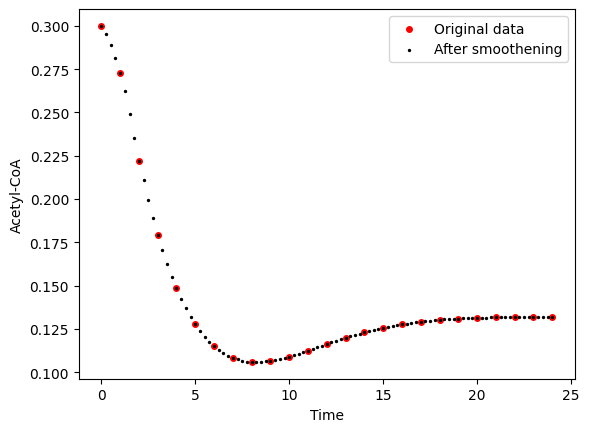

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


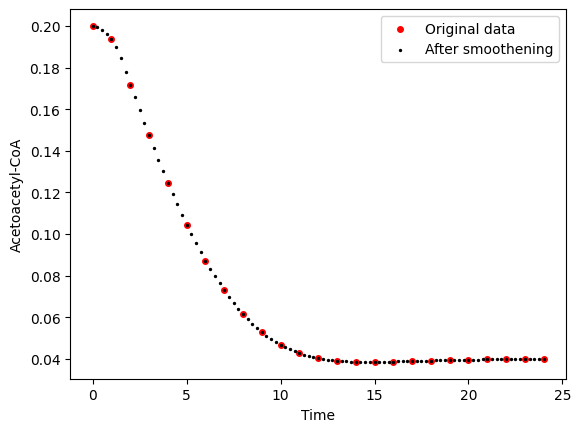

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


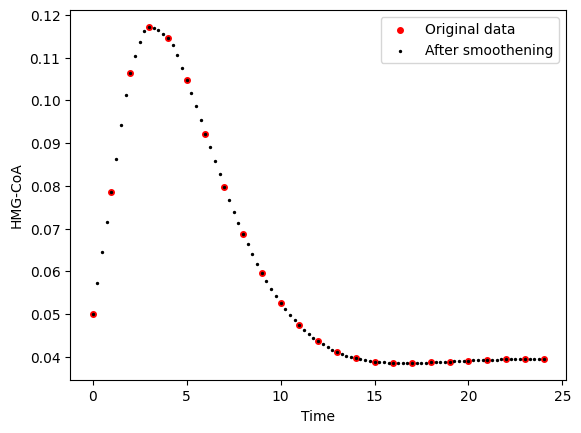

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


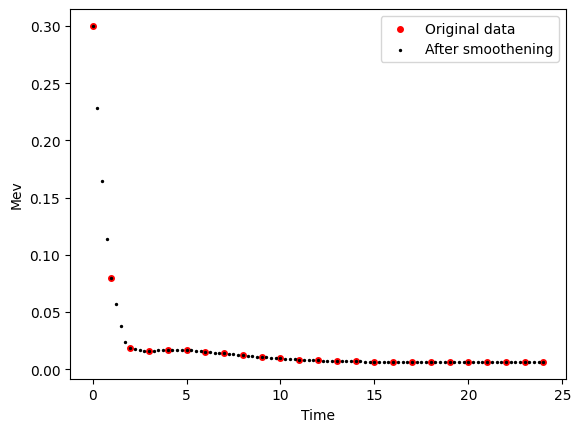

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


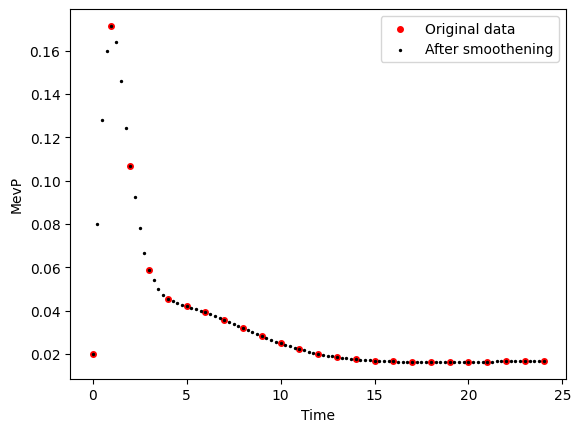

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


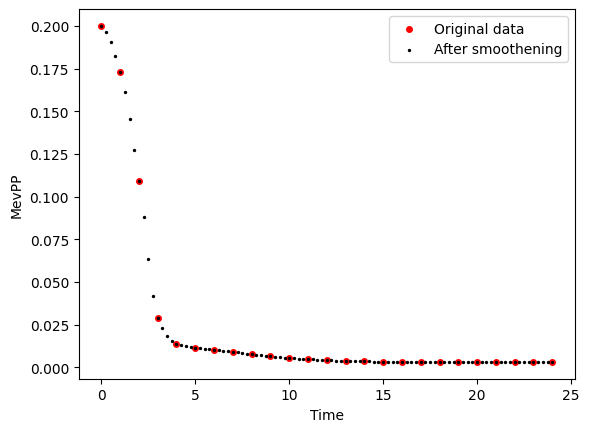

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


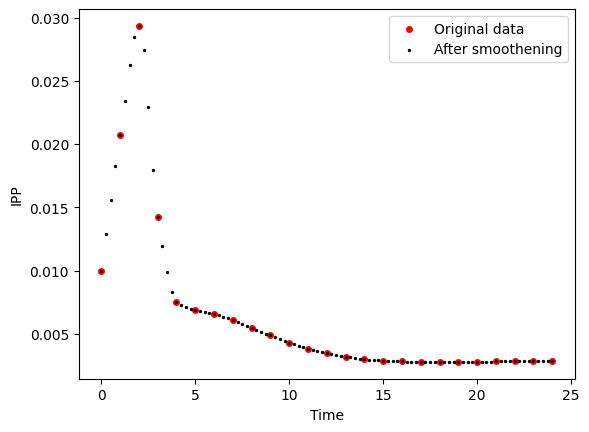

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


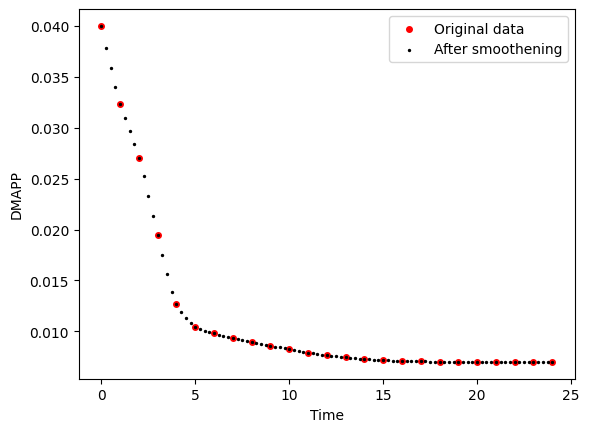

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


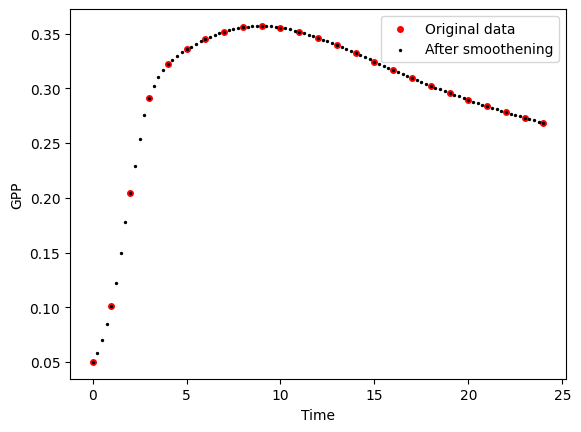

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


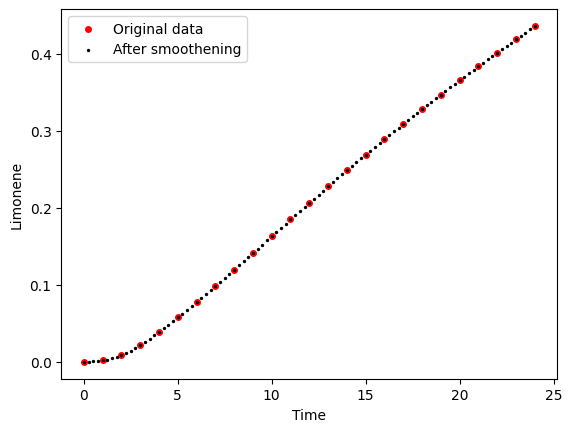

Strain Strain 2


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


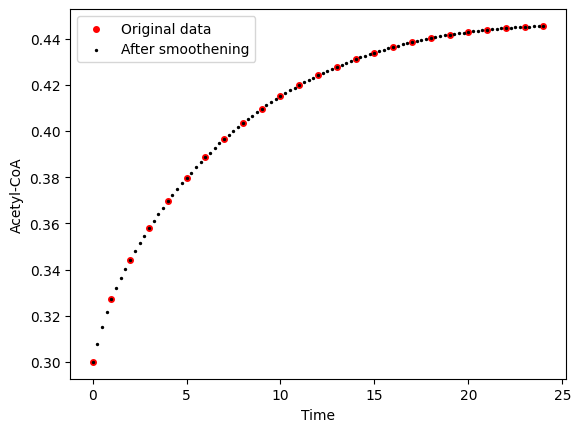

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


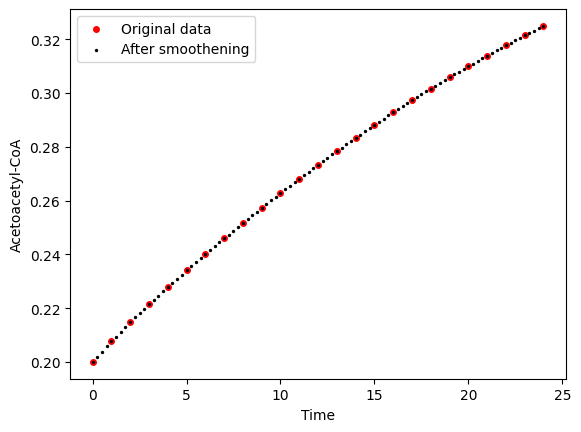

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


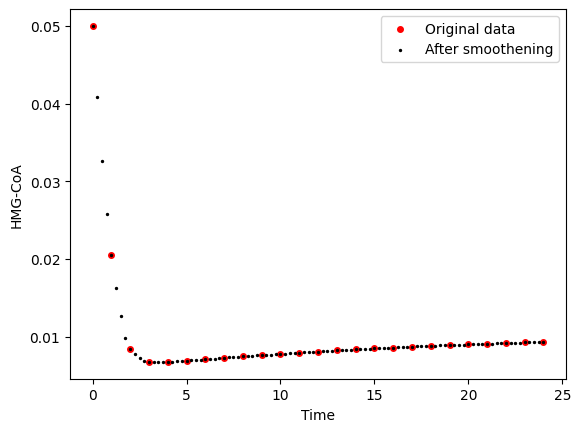

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


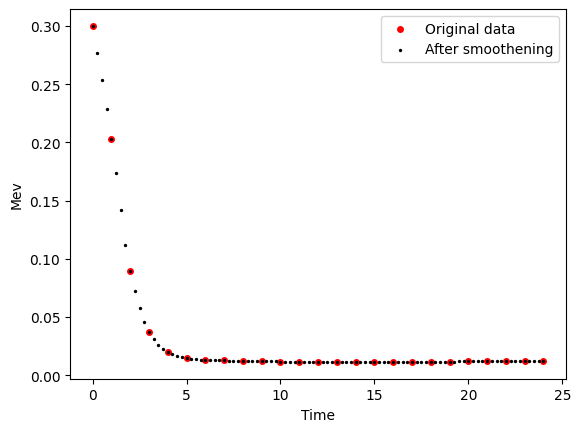

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


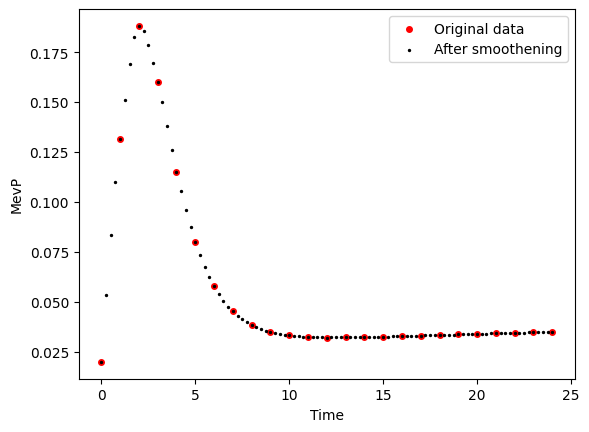

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


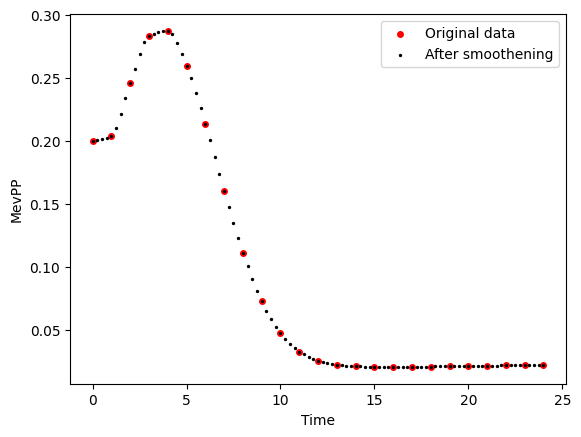

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


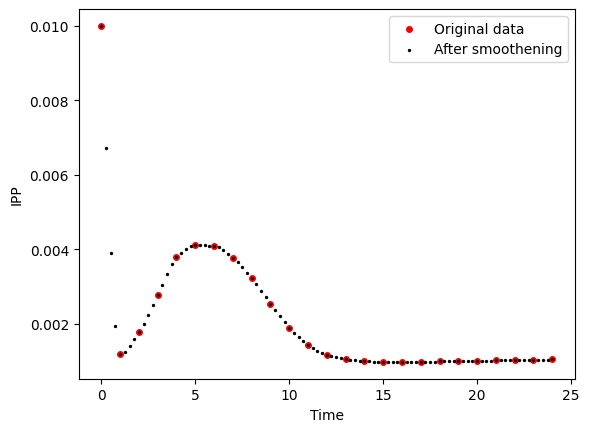

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


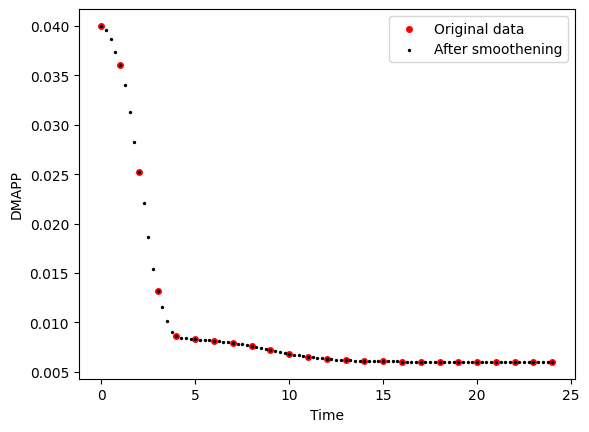

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


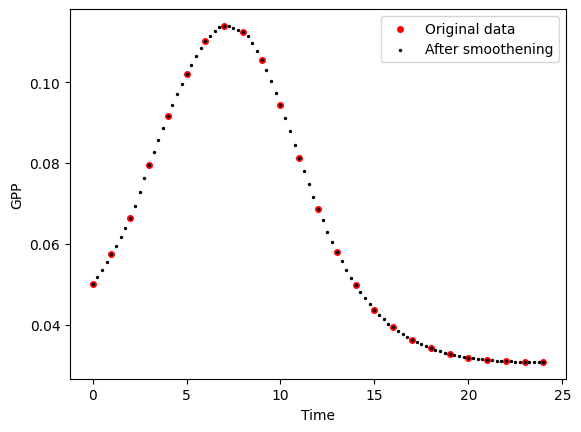

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


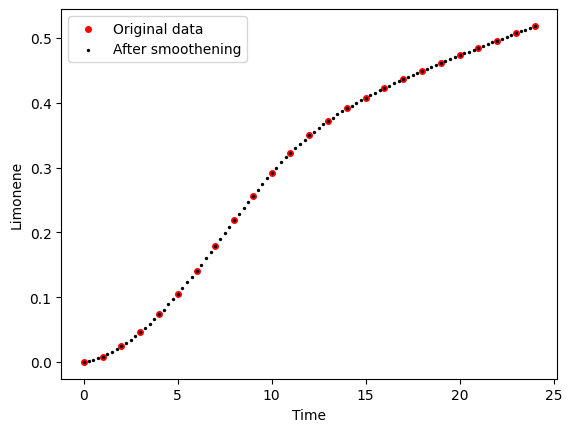

Strain Strain 3


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


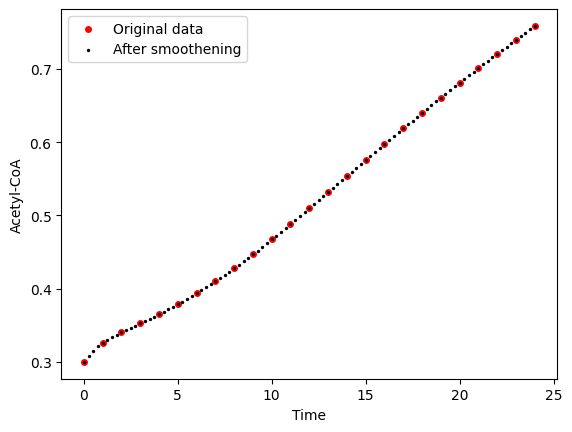

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


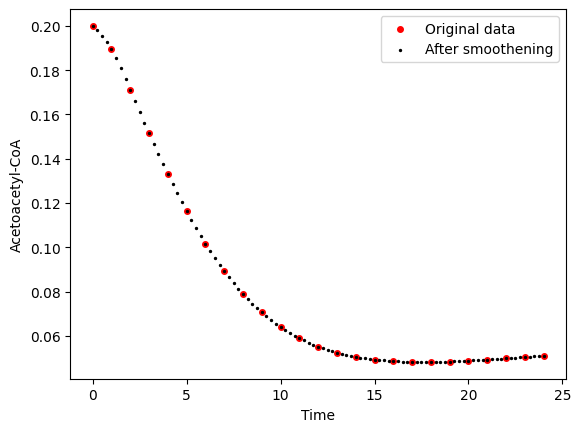

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


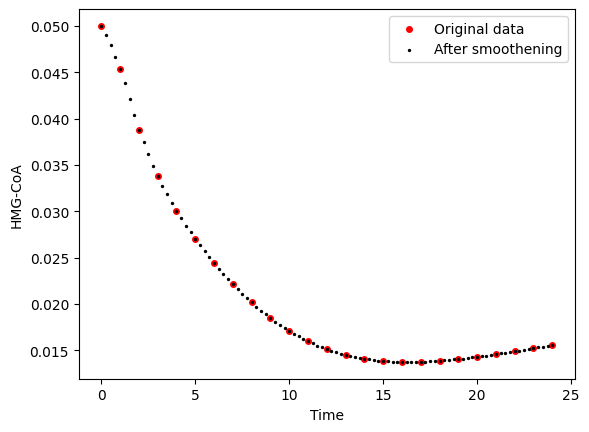

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


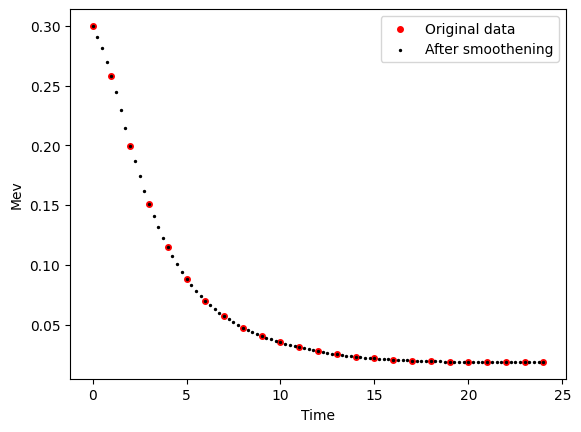

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


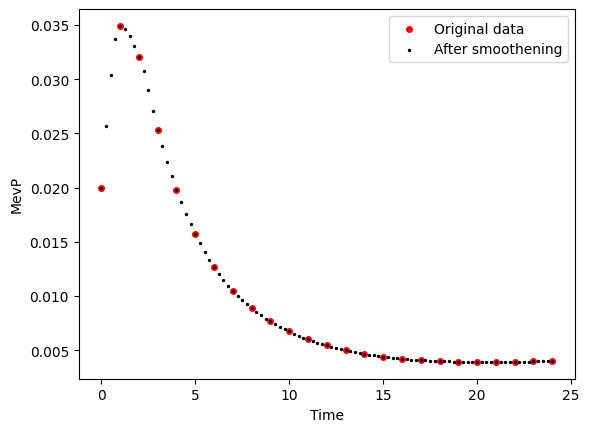

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


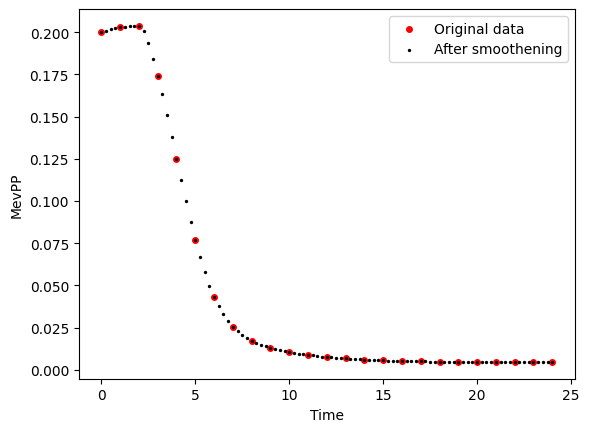

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


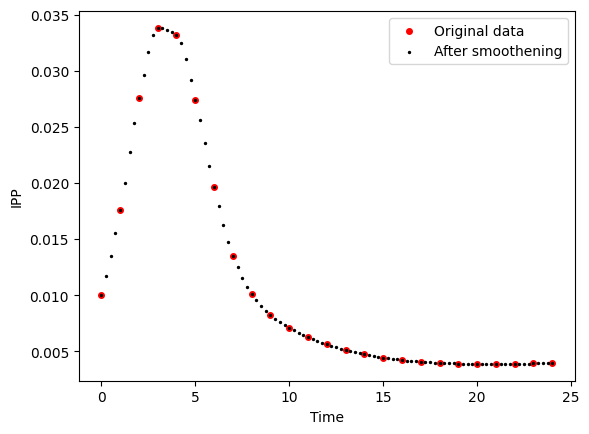

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


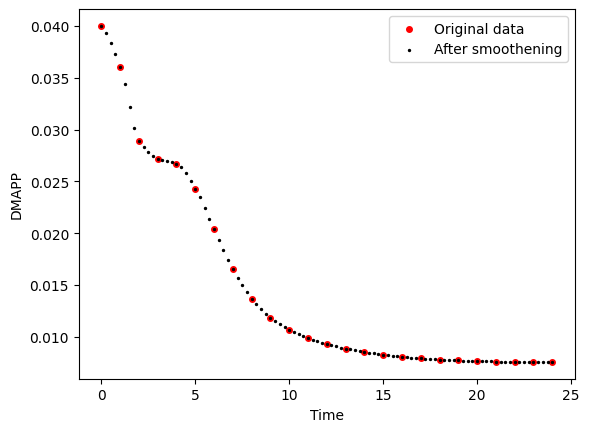

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


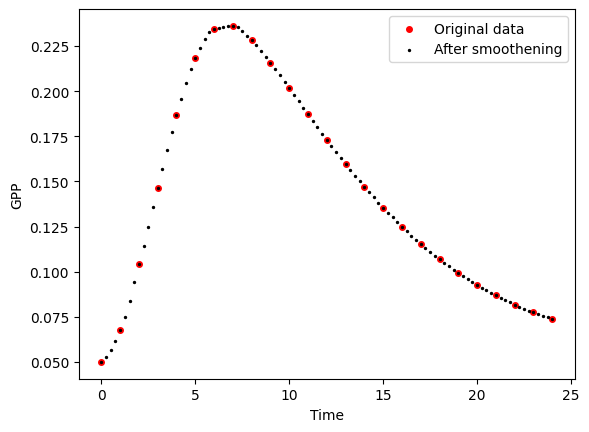

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


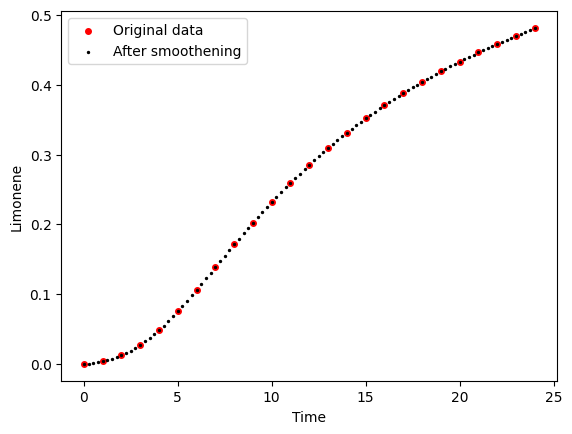

Strain WT


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


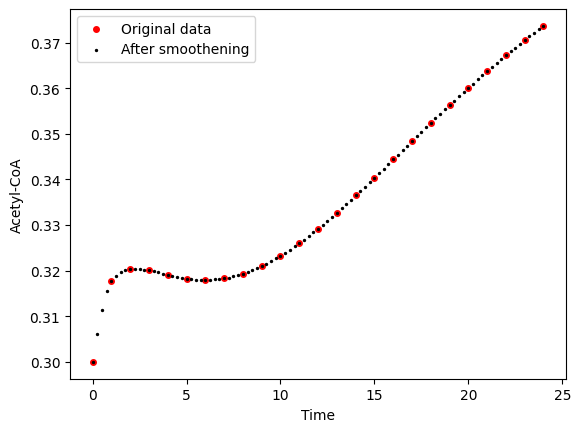

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


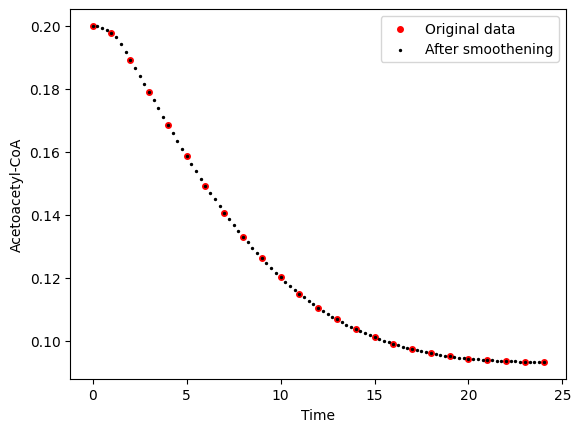

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


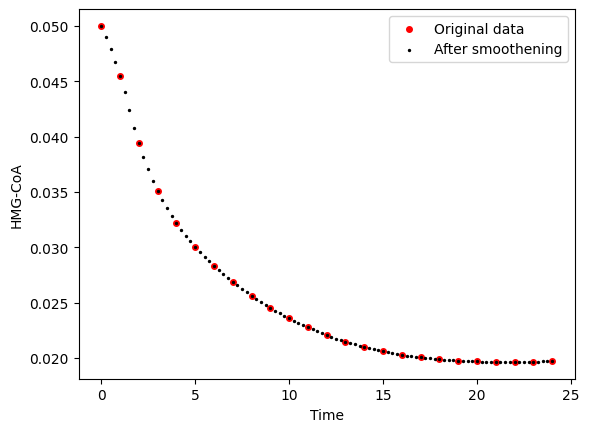

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


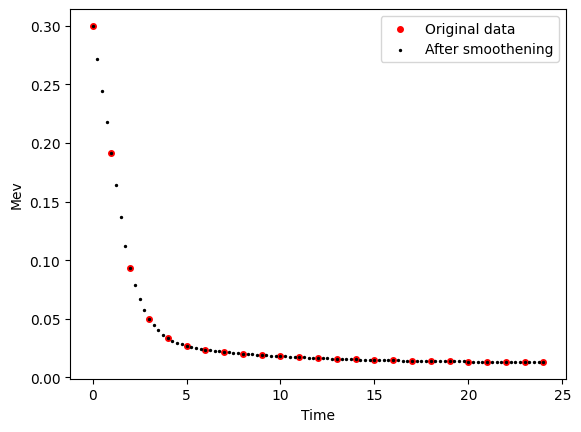

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


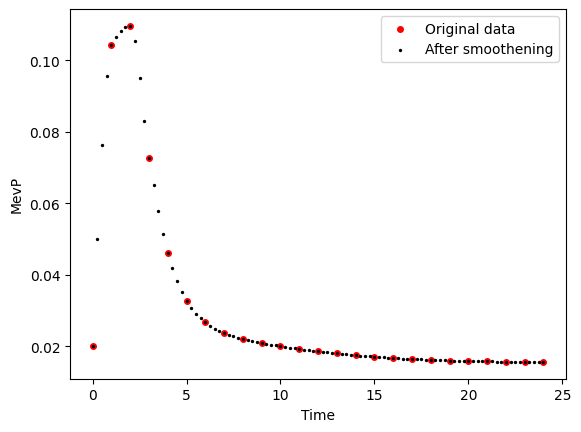

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


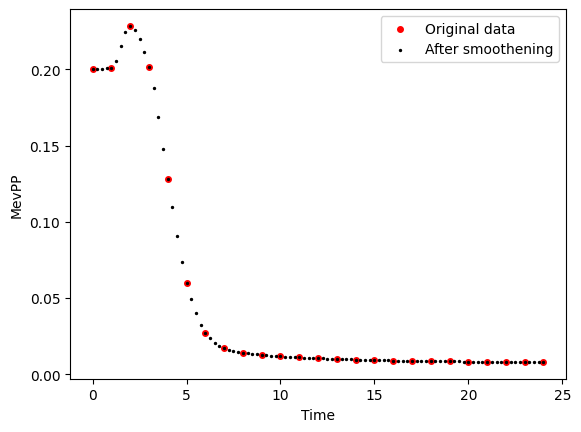

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


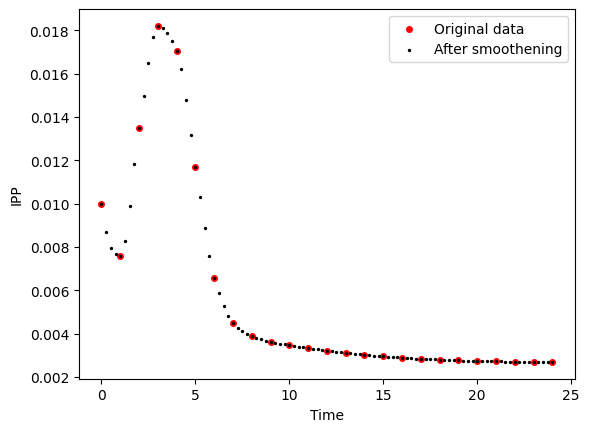

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


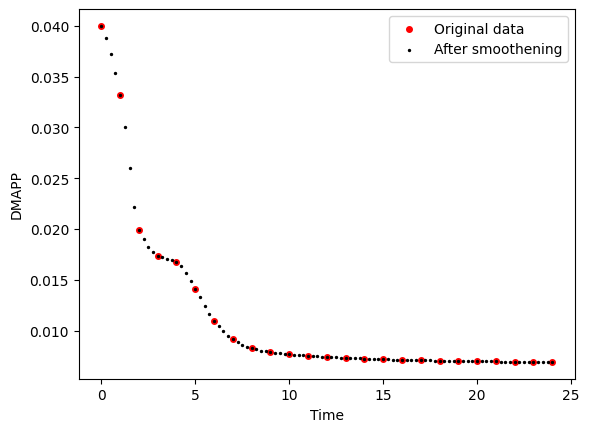

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


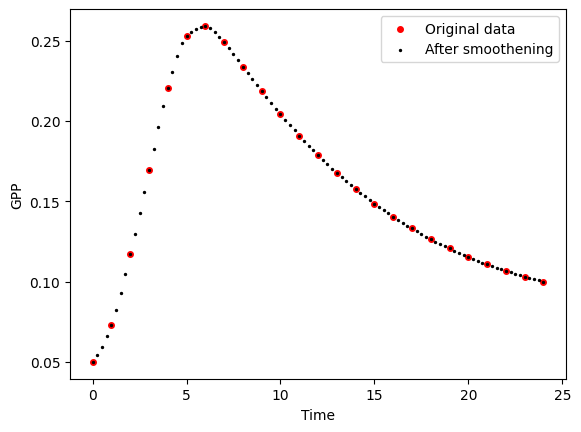

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


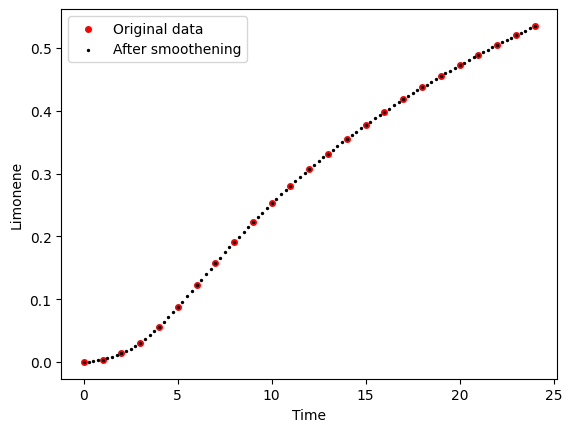

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


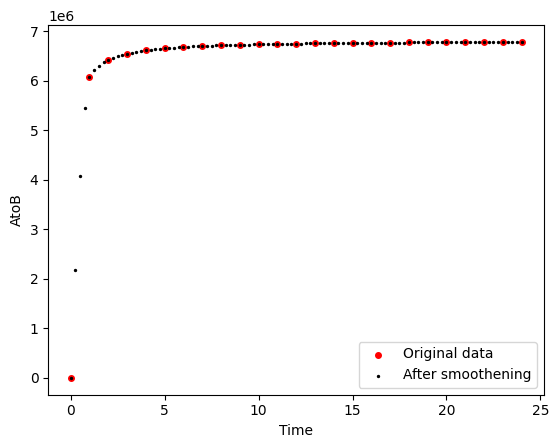

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


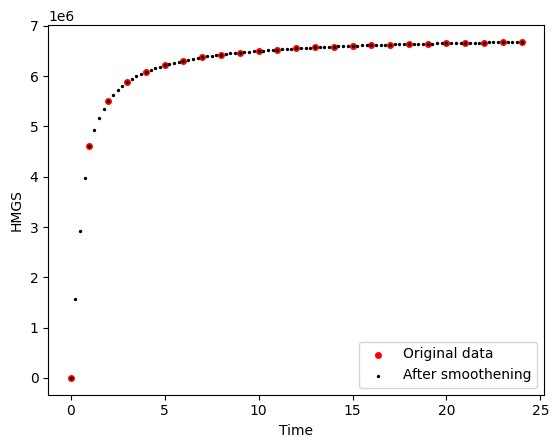

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


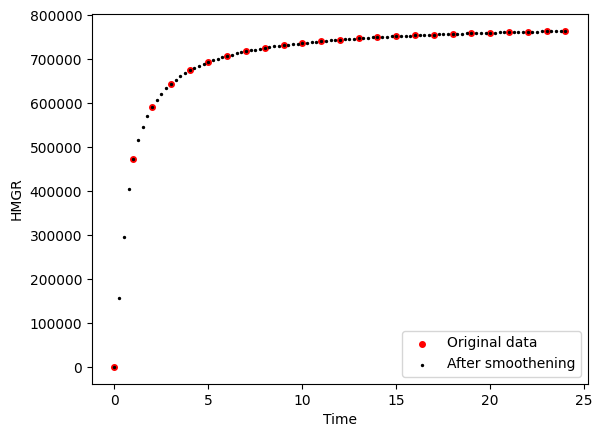

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


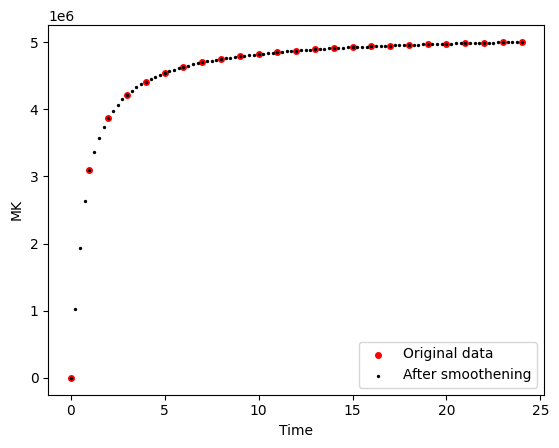

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


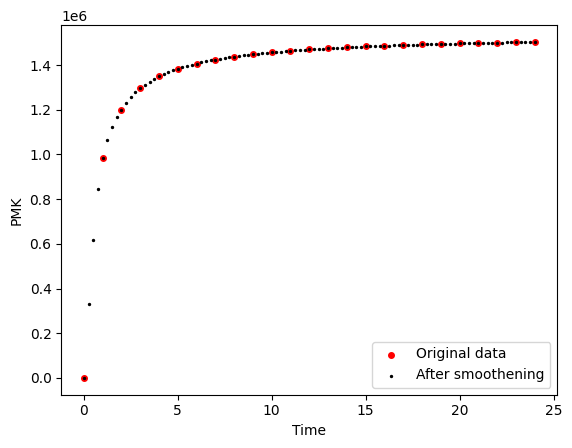

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


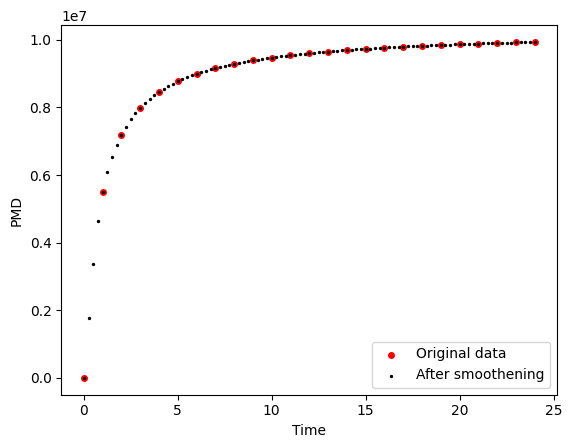

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


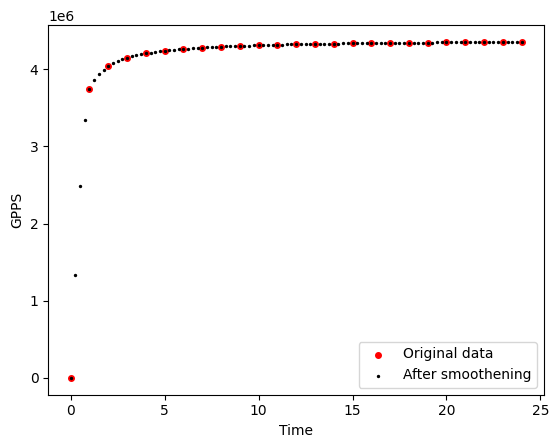

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


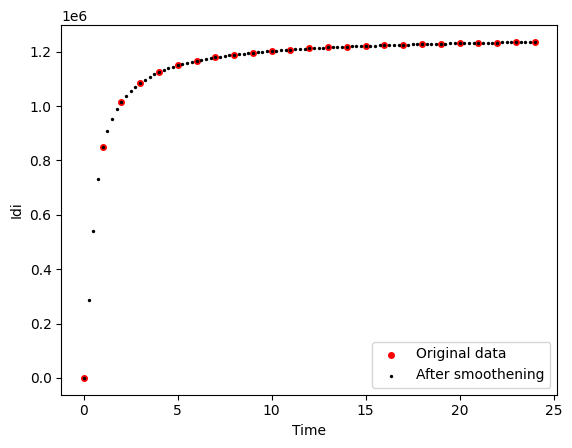

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


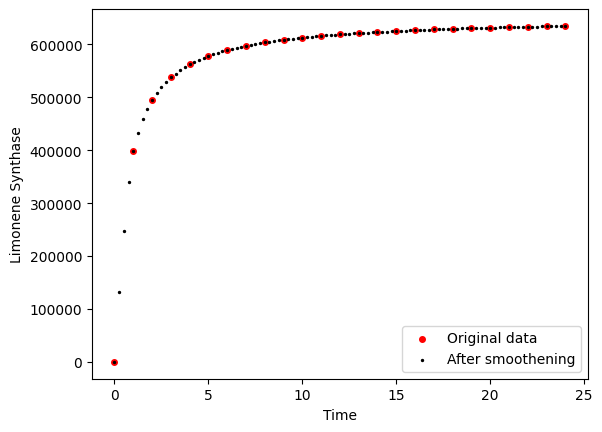

Strain Strain 2


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


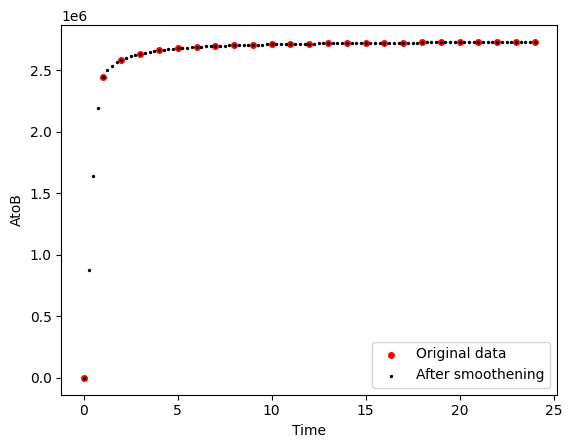

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


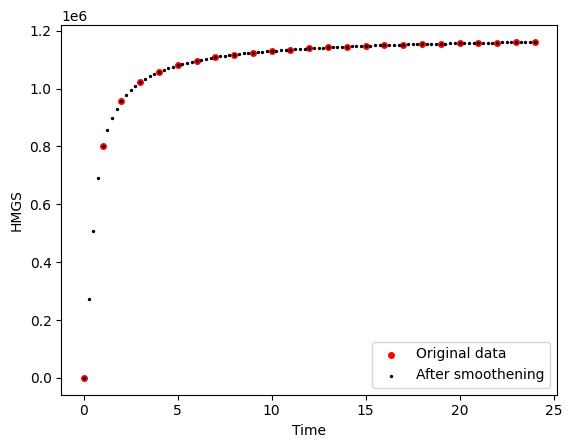

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


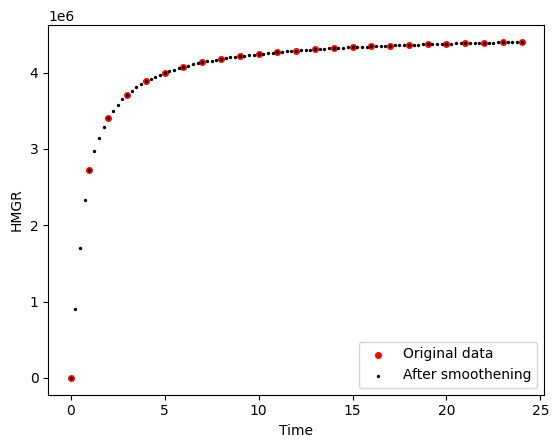

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


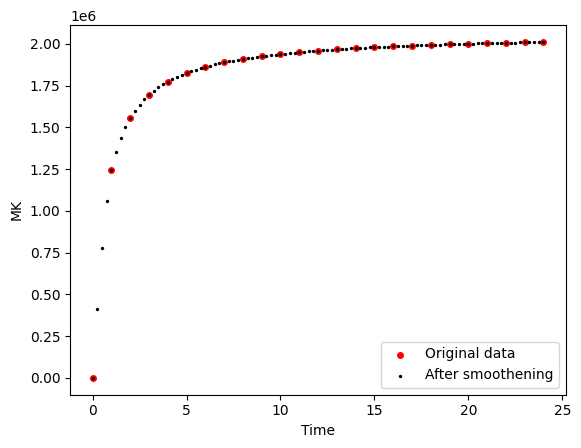

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


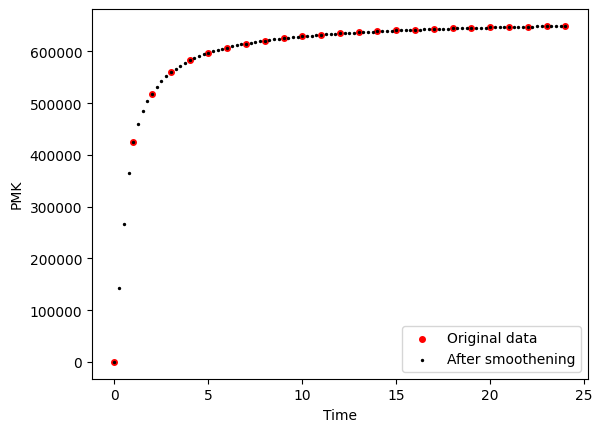

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


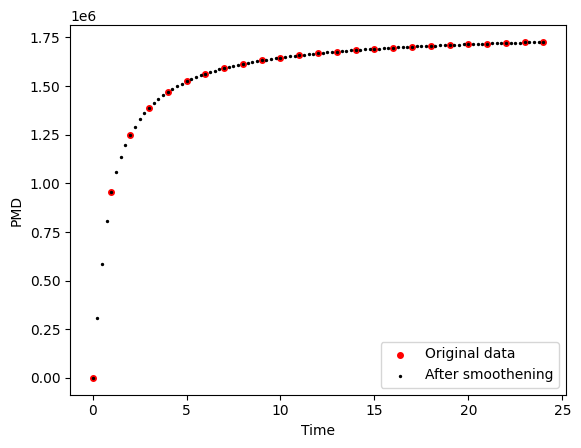

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


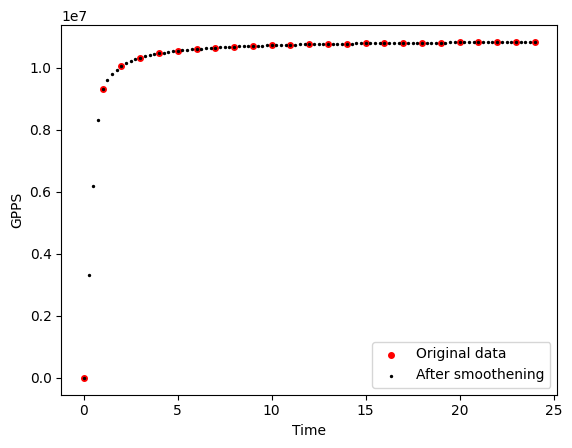

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


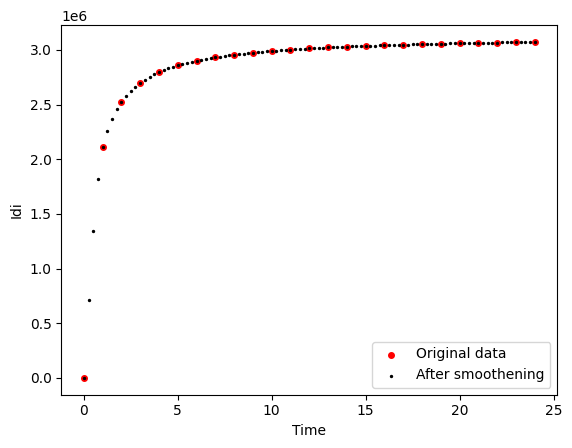

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


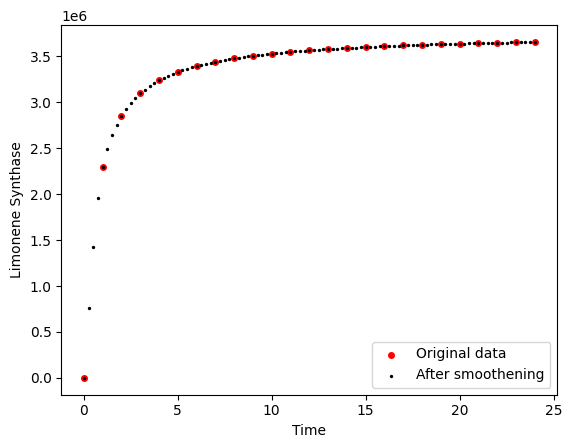

Strain Strain 3


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


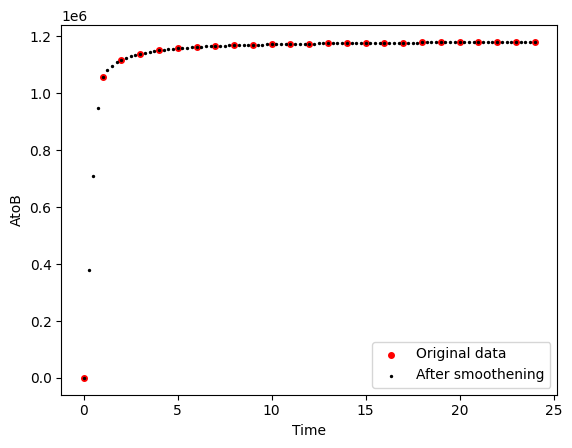

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


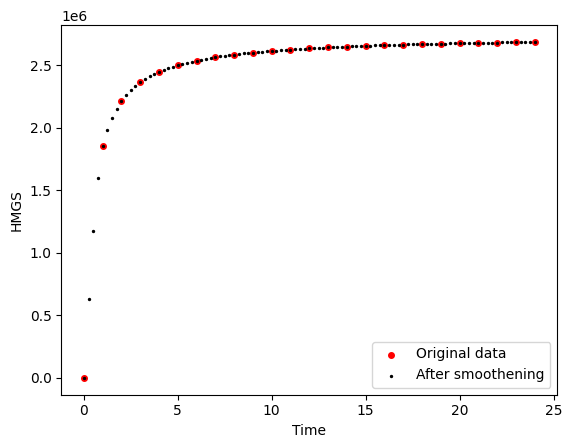

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


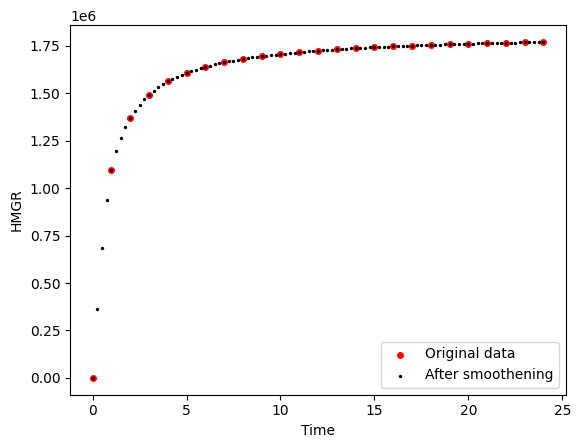

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


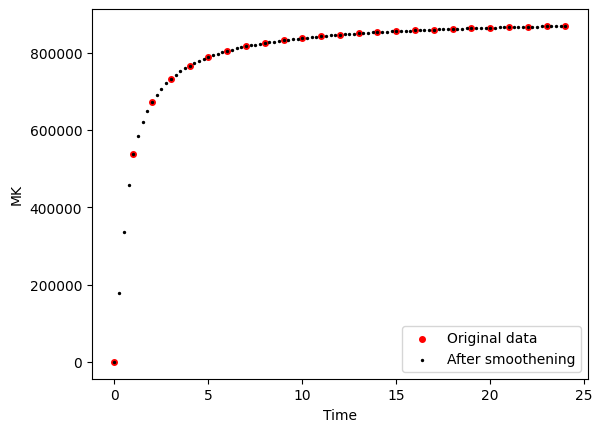

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


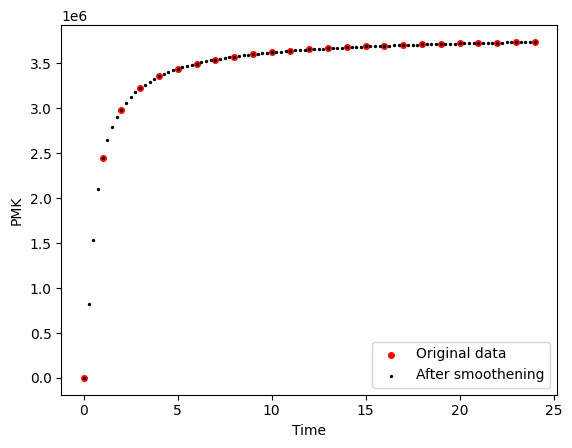

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


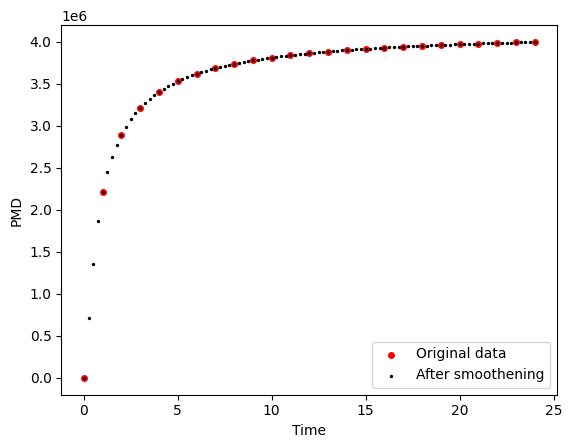

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


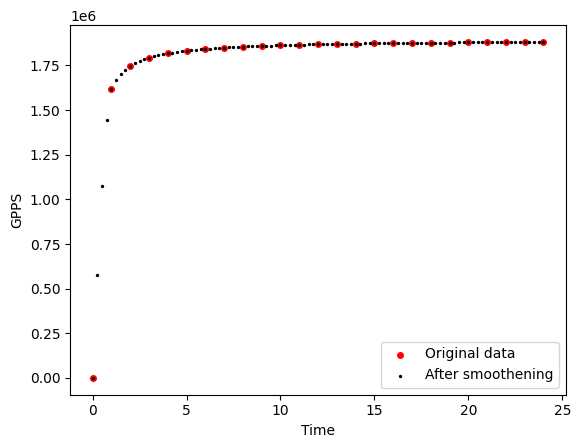

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


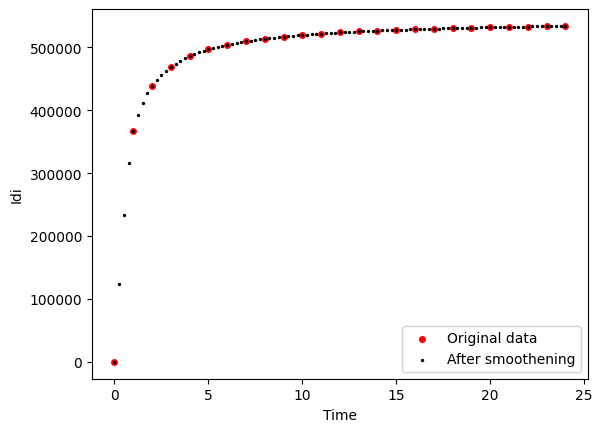

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


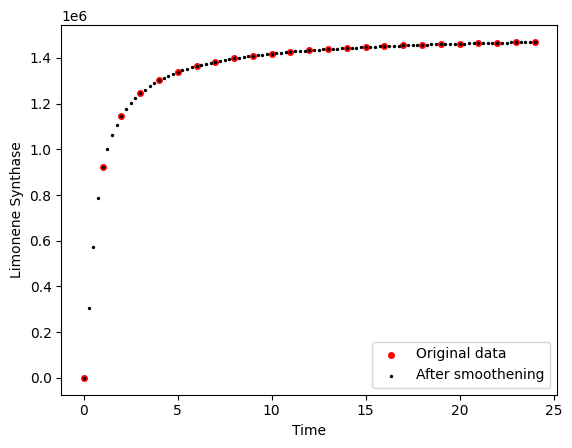

Strain WT


C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


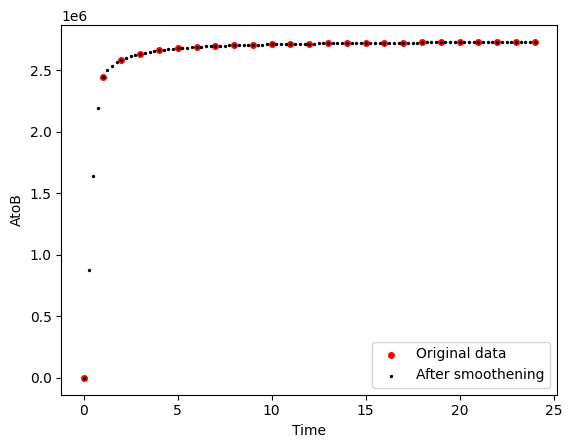

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


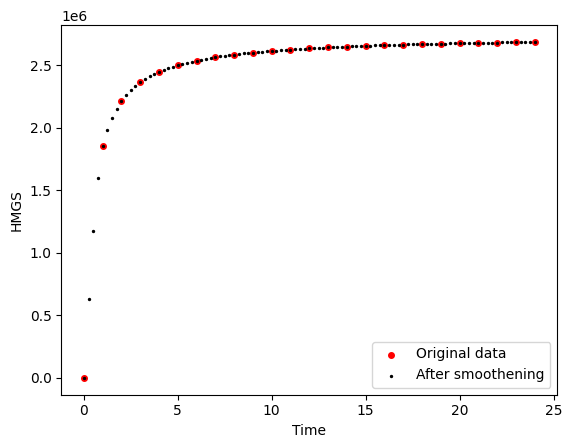

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


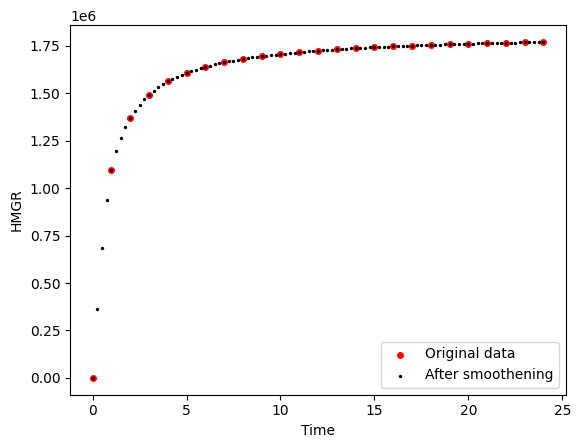

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


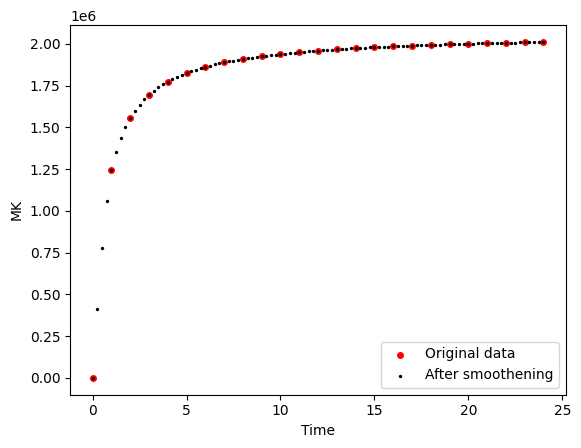

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


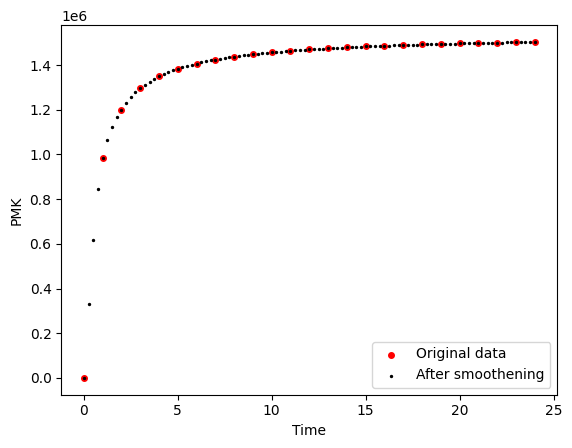

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


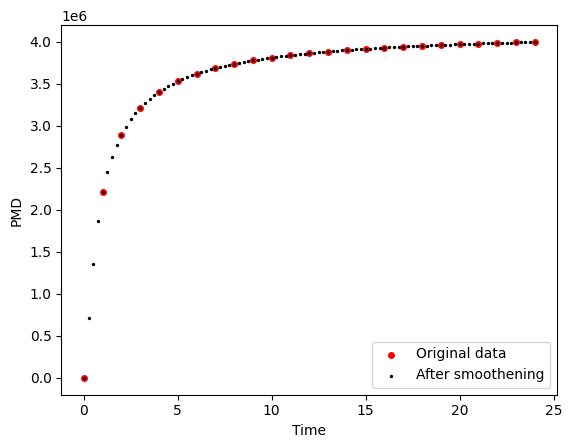

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


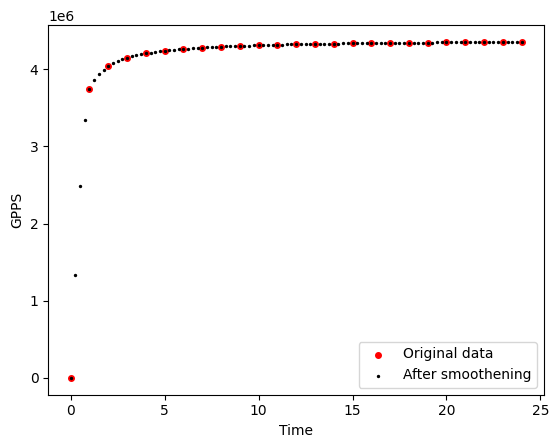

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


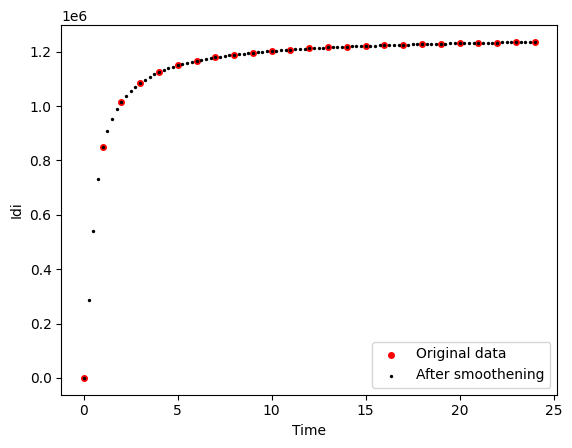

C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\yeohc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


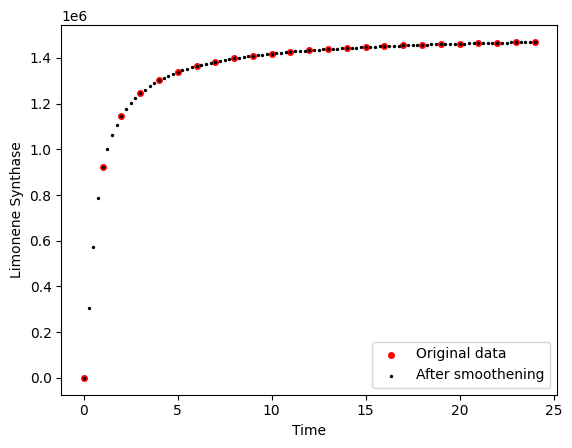

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.295304        0.199481  0.057238  0.228027  0.080140   
         0.50    0.289011        0.198098  0.064423  0.164564  0.128121   
         0.75    0.281460        0.196107  0.071556  0.113784  0.159885   
         1.00    0.272992        0.193767  0.078634  0.079861  0.171375   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.370558        0.093309  0.019650  0.013135  0.015658   
         23.25   0.371355        0.093286  0.019658  0.013121  0.015650   
         23.50   0.372140        0.093266  0.019668  0.013108  0.015644   
         23.75   0.372913        0.093252  0.019679  0.013096  0.015638   
         24.00   0.373674        0.093246  0.019692  0.013086  0.015634   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.196426  0.012875  0.037870  0.058186  0.000160  ...   
         0.50   0.190286  0.015624  0.035876  0.069948  0.000587  ...   
         0.75   0.182295  0.018236  0.034037  0.084443  0.001203  ...   
         1.00   0.173169  0.020703  0.032371  0.100826  0.001928  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.008076  0.002704  0.006927  0.103119  0.520339  ...   
         23.25  0.008068  0.002702  0.006924  0.102295  0.524111  ...   
         23.50  0.008061  0.002701  0.006921  0.101496  0.527854  ...   
         23.75  0.008054  0.002700  0.006919  0.100724  0.531567  ...   
         24.00  0.008049  0.002700  0.006916  0.099981  0.535250  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.018818       -0.003165  0.029795 -0.330891  0.284113   
         0.25    -0.021934       -0.003775  0.028744 -0.272249  0.218423   
         0.50    -0.026349       -0.005583  0.028311 -0.218068  0.152011   
         0.75    -0.032063       -0.008588  0.028496 -0.168347  0.084877   
         1.00    -0.039157       -0.012605  0.029715 -0.116333  0.007035   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003210       -0.000108  0.000031 -0.000058 -0.000033   
         23.25    0.003162       -0.000084  0.000036 -0.000053 -0.000028   
         23.50    0.003115       -0.000061  0.000041 -0.000048 -0.000023   
         23.75    0.003069       -0.000041  0.000047 -0.000044 -0.000019   
         24.00    0.003023       -0.000026  0.000054 -0.000039 -0.000015   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.014552  0.012289 -0.008785  0.033298  0.000884  
         0.25  -0.019532  0.011184 -0.008270  0.039830  0.001179  
         0.50  -0.026064  0.010489 -0.007674  0.049327  0.001767  
         0.75  -0.034148  0.010203 -0.006995  0.061788  0.002647  
         1.00  -0.043159  0.010581 -0.006134  0.077241  0.003699  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.000035 -0.000006 -0.000012 -0.003354  0.015143  
         23.25 -0.000031 -0.000005 -0.000012 -0.003246  0.015029  
         23.50 -0.000027 -0.000004 -0.000011 -0.003137  0.014911  
         23.75 -0.000024 -0.000003 -0.000010 -0.003029  0.014793  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

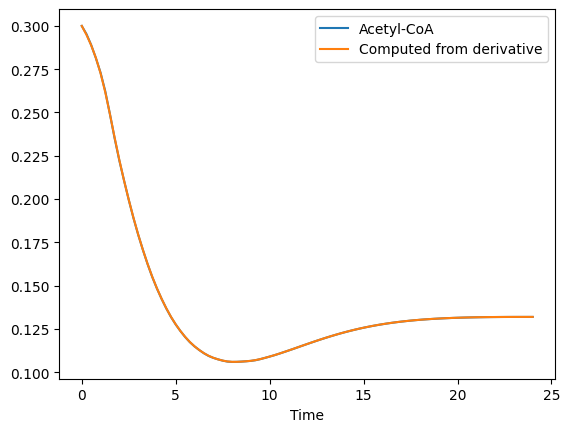

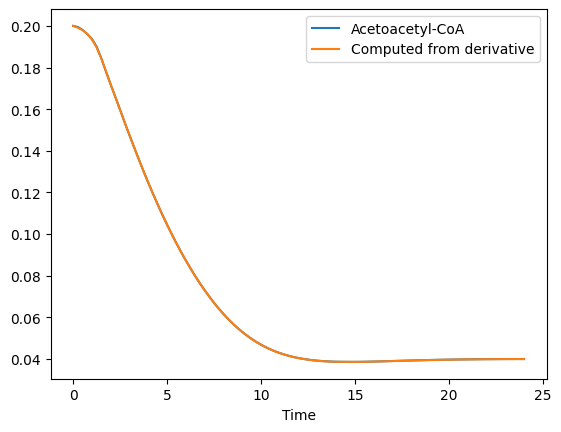

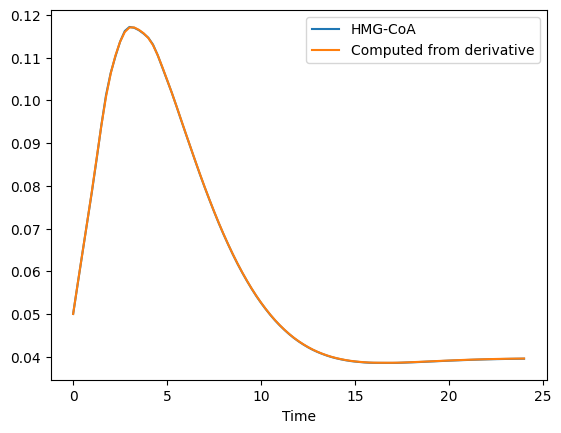

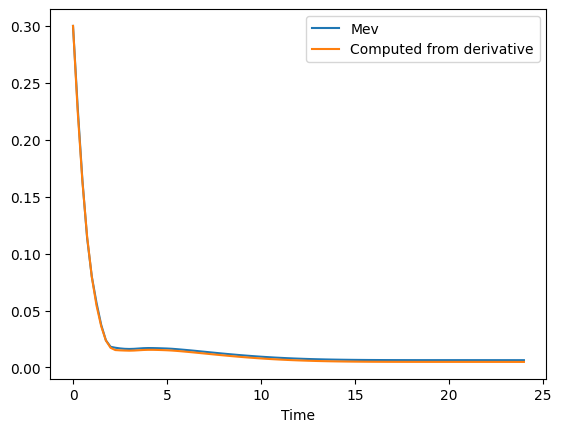

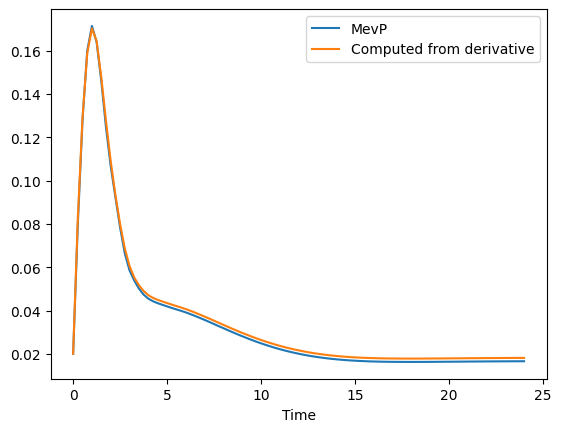

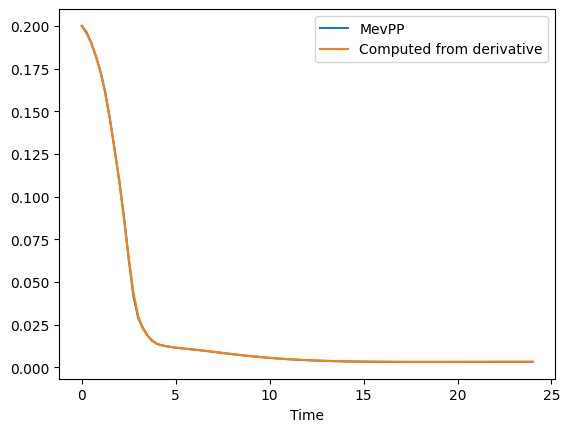

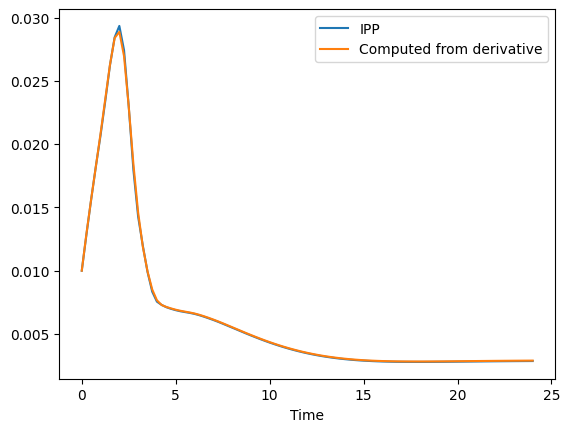

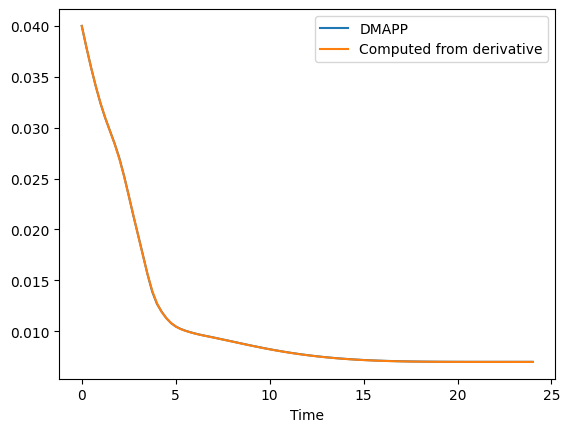

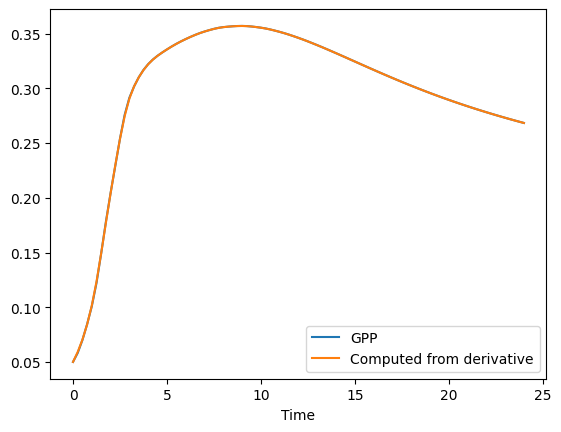

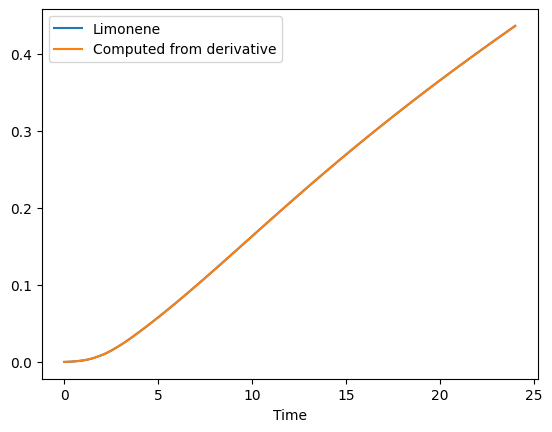

'Time profile from derivative vs. actual profile for Strain 2'

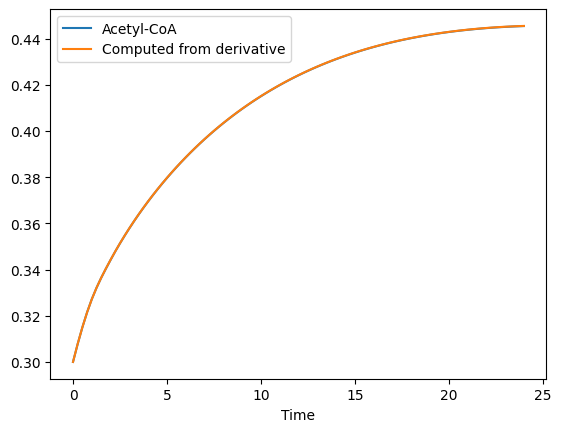

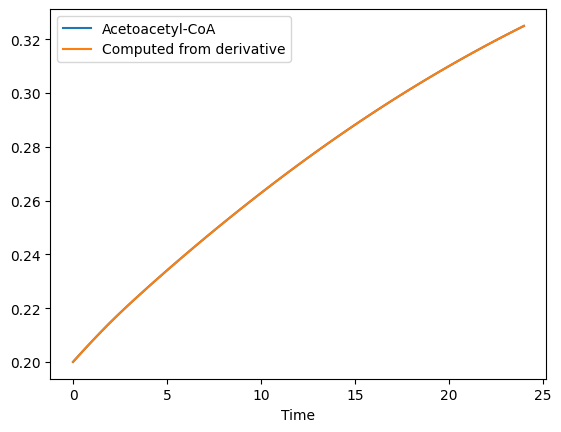

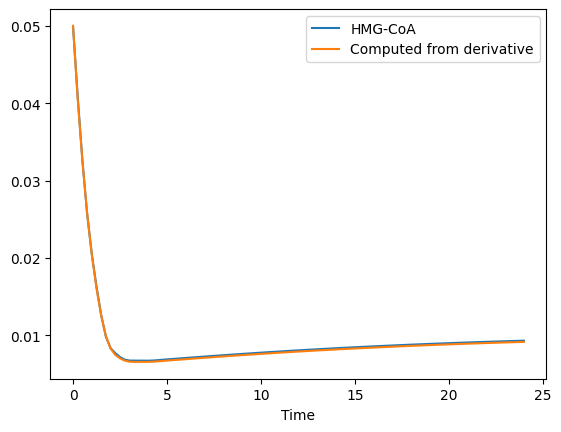

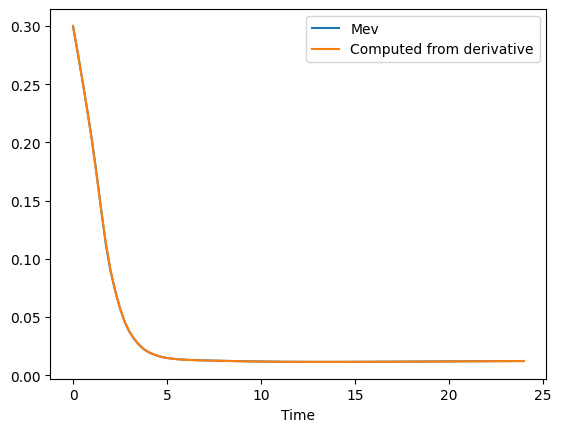

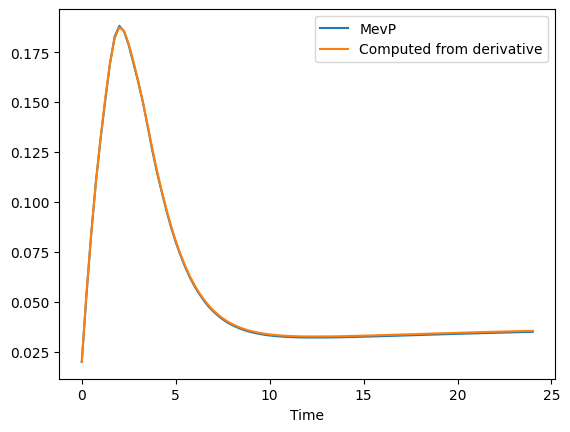

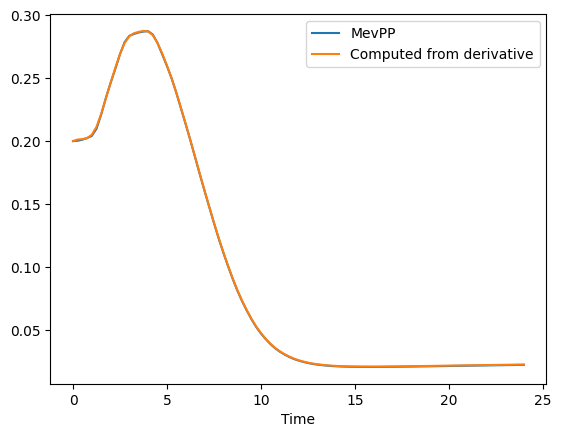

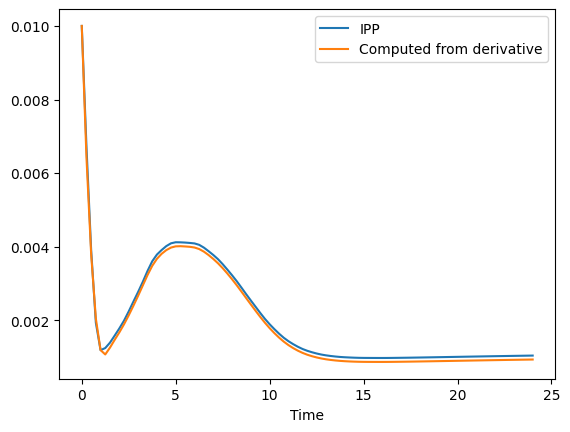

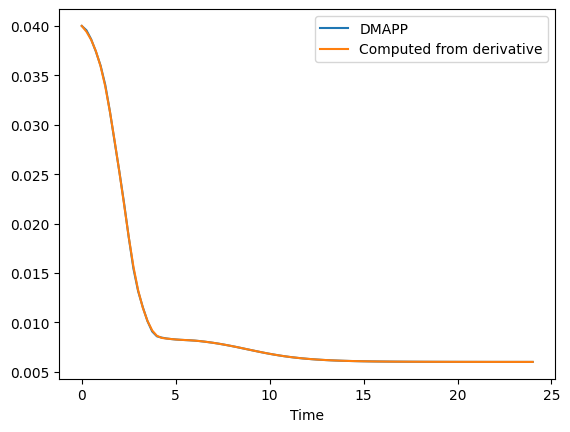

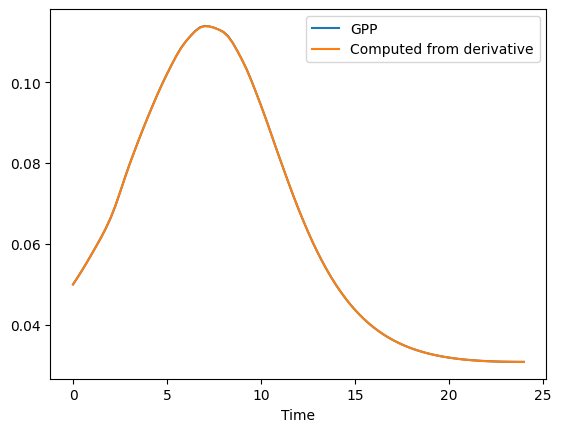

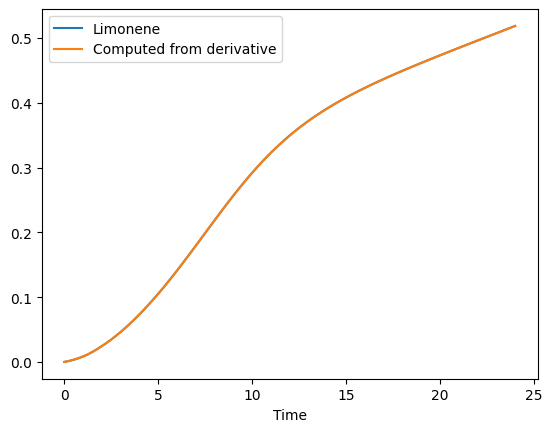

'Time profile from derivative vs. actual profile for Strain 3'

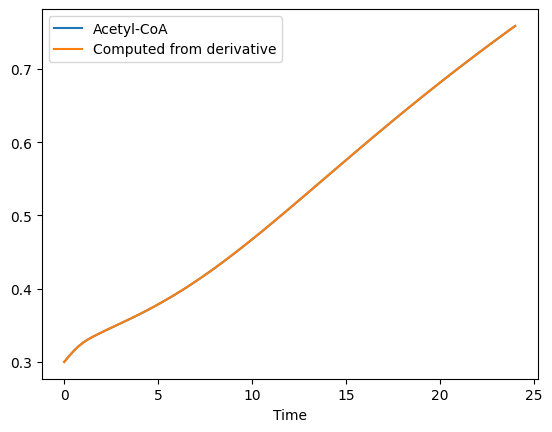

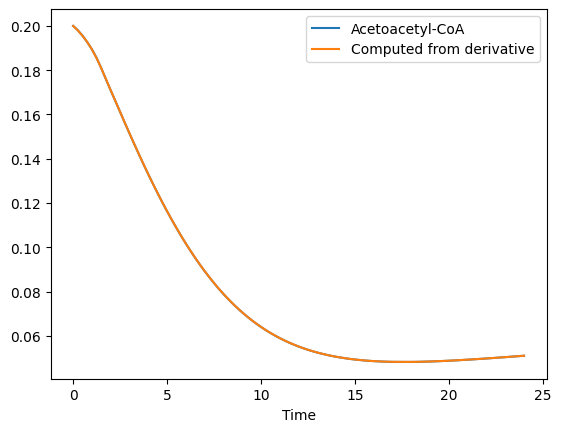

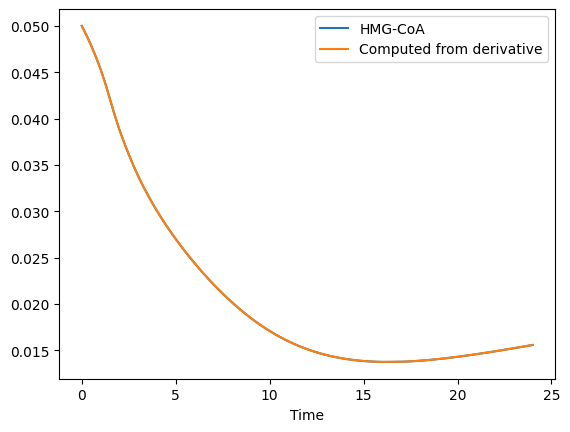

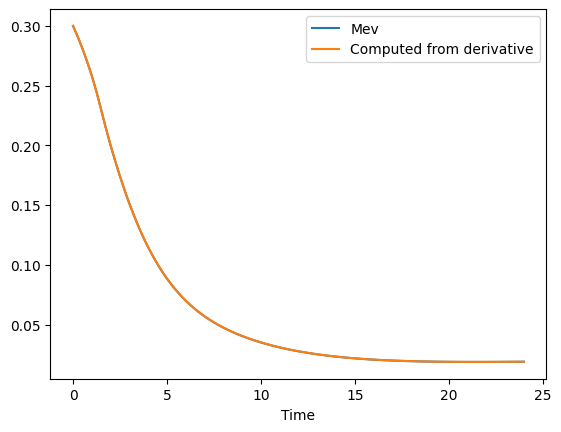

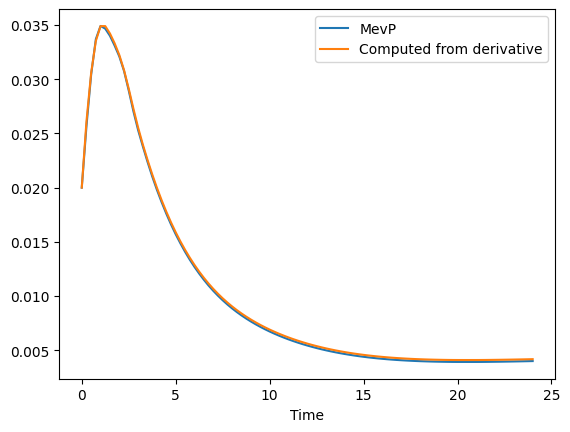

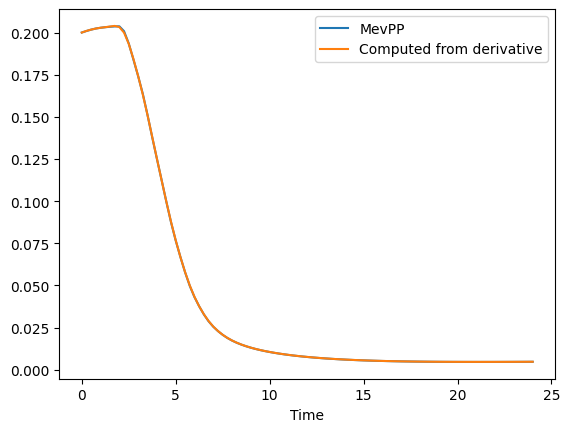

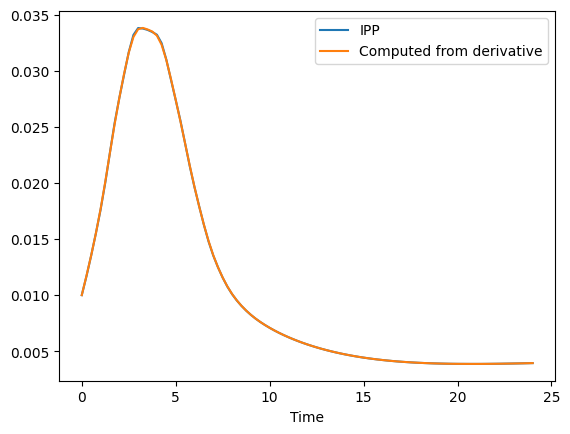

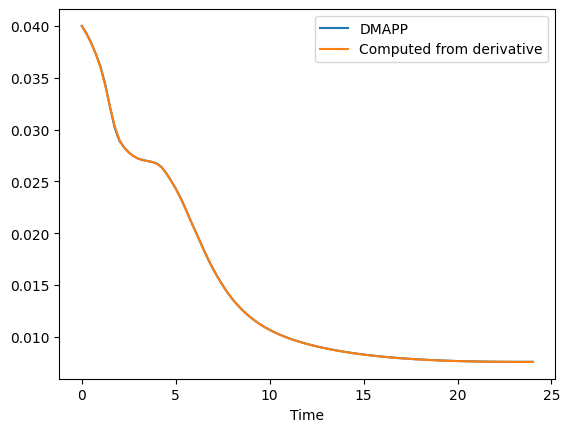

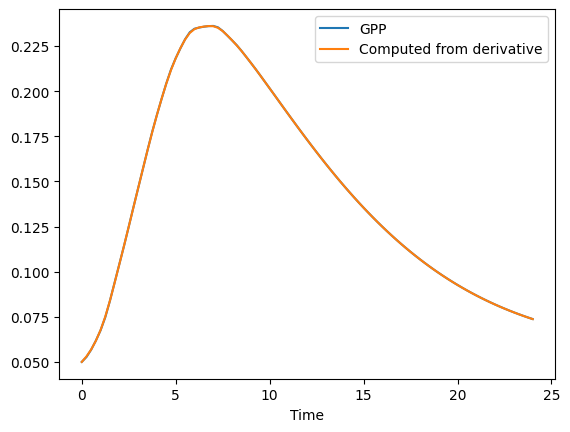

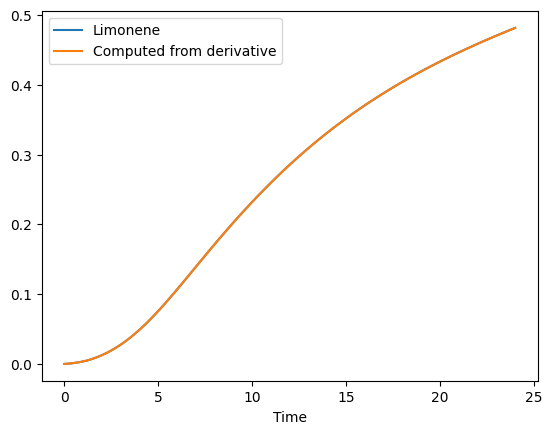

'Time profile from derivative vs. actual profile for WT'

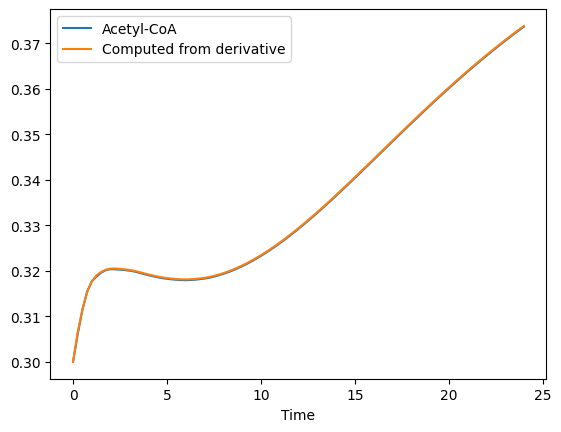

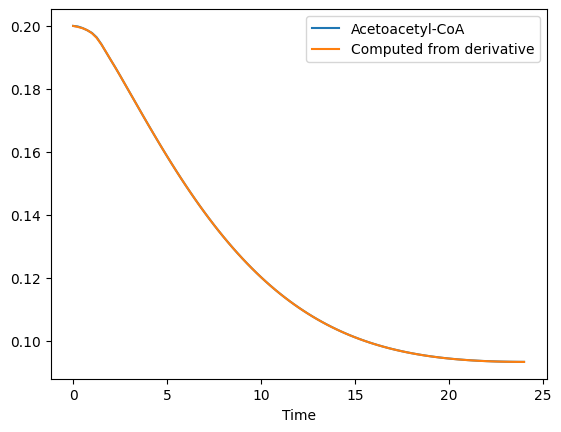

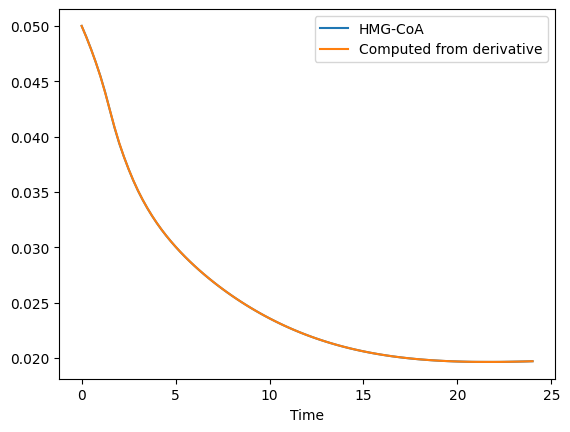

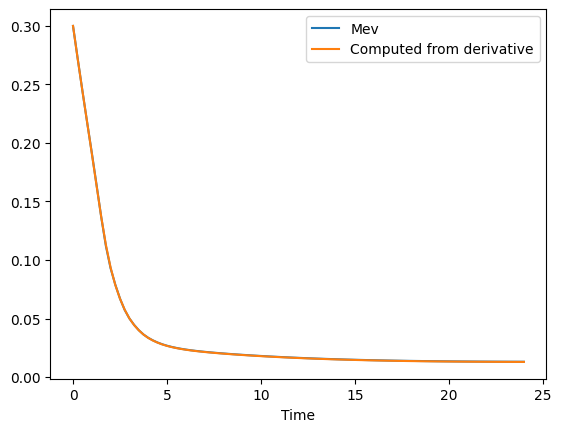

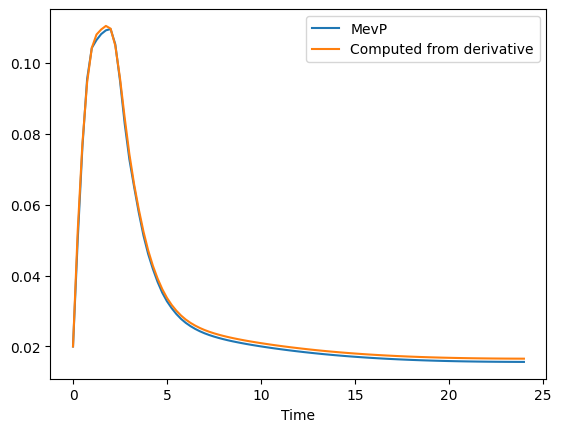

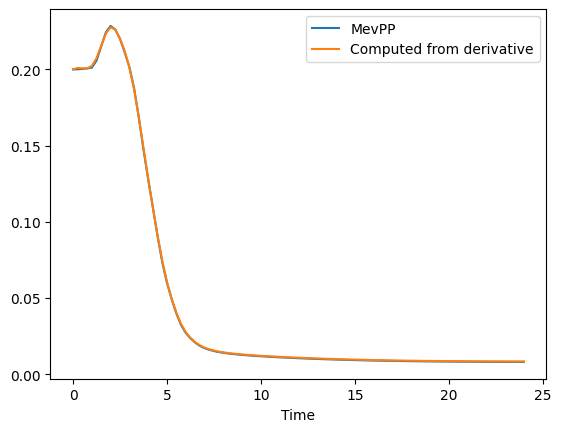

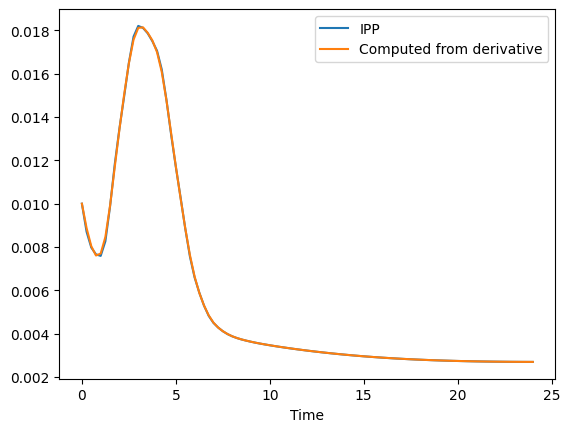

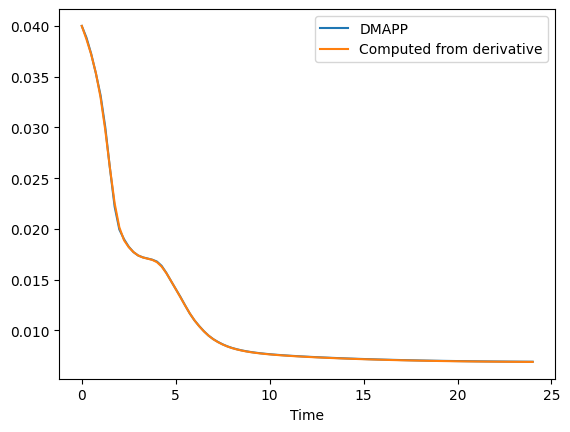

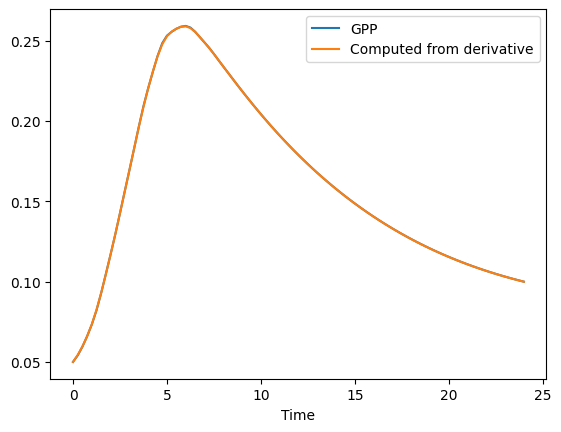

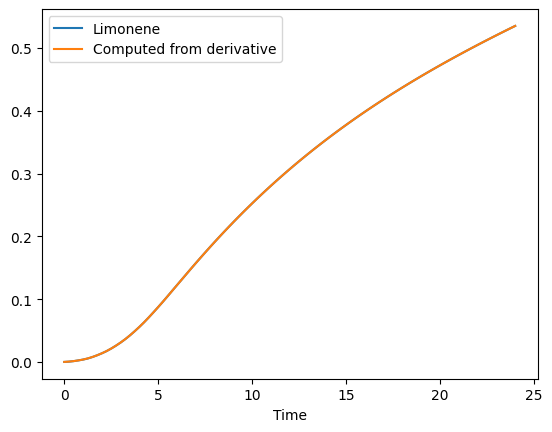

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   2.173781e+06  1.560234e+06  1.570374e+05  1.025868e+06   
         0.50   4.069572e+06  2.927241e+06  2.951031e+05  1.927997e+06   
         0.75   5.448752e+06  3.983103e+06  4.041436e+05  2.640608e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768629e+06  2.010384e+06   
         23.50  2.729713e+06  2.686646e+06  1.769147e+06  2.010975e+06   
         23.75  2.729864e+06  2.687210e+06  1.769654e+06  2.011553e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   3.297925e+05  1.785807e+06  1.328120e+06  2.871277e+05   
         0.50   6.192067e+05  3.363592e+06  2.486684e+06  5.387196e+05   
         0.75   8.452060e+05  4.637042e+06  3.337821e+06  7.332309e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992255e+06  4.354150e+06  1.235379e+06   
         23.50  1.502404e+06  3.993787e+06  4.354490e+06  1.235648e+06   
         23.75  1.502773e+06  3.995286e+06  4.354823e+06  1.235911e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.321864e+05   0.295304        0.199481  0.057238   
         0.50       2.483535e+05   0.289011        0.198098  0.064423   
         0.75       3.398863e+05   0.281460        0.196107  0.071556   
         1.00       3.981392e+05   0.272992        0.193767  0.078634   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.370558        0.093309  0.019650   
         23.25      1.468435e+06   0.371355        0.093286  0.019658   
         23.50      1.468852e+06   0.372140        0.093266  0.019668   
         23.75      1.469260e+06   0.372913        0.093252  0.019679   
         24.00      1.469659e+06   0.373674        0.093246  0.019692   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.228027  0.080140  0.196426  0.012875  0.037870  0.058186   
         0.50   0.164564  0.128121  0.190286  0.015624  0.035876  0.069948   
         0.75   0.113784  0.159885  0.182295  0.018236  0.034037  0.084443   
         1.00   0.079861  0.171375  0.173169  0.020703  0.032371  0.100826   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.013135  0.015658  0.008076  0.002704  0.006927  0.103119   
         23.25  0.013121  0.015650  0.008068  0.002702  0.006924  0.102295   
         23.50  0.013108  0.015644  0.008061  0.002701  0.006921 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.018818       -0.003165  0.029795 -0.330891  0.284113   
         0.25    -0.021934       -0.003775  0.028744 -0.272249  0.218423   
         0.50    -0.026349       -0.005583  0.028311 -0.218068  0.152011   
         0.75    -0.032063       -0.008588  0.028496 -0.168347  0.084877   
         1.00    -0.039157       -0.012605  0.029715 -0.116333  0.007035   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003210       -0.000108  0.000031 -0.000058 -0.000033   
         23.25    0.003162       -0.000084  0.000036 -0.000053 -0.000028   
         23.50    0.003115       -0.000061  0.000041 -0.000048 -0.000023   
         23.75    0.003069       -0.000041  0.000047 -0.000044 -0.000019   
         24.00    0.003023       -0.000026  0.000054 -0.000039 -0.000015   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.014552  0.012289 -0.008785  0.033298  0.000884  
         0.25  -0.019532  0.011184 -0.008270  0.039830  0.001179  
         0.50  -0.026064  0.010489 -0.007674  0.049327  0.001767  
         0.75  -0.034148  0.010203 -0.006995  0.061788  0.002647  
         1.00  -0.043159  0.010581 -0.006134  0.077241  0.003699  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.000035 -0.000006 -0.000012 -0.003354  0.015143  
         23.25 -0.000031 -0.000005 -0.000012 -0.003246  0.015029  
         23.50 -0.000027 -0.000004 -0.000011 -0.003137  0.014911  
         23.75 -0.000024 -0.000003 -0.000010 -0.003029  0.014793  
         24.00 -0.000021 -0.000002 -0.000009 -0.002923  0.014674  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# problem definition (object oriented to use population-based approach)
class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=34, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,-1.30103,0.0                         
                         ]), # lower bounds
                         xu=np.array([
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,-1.301029,9.0
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                      s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                      k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                      k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                      k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
        #HC: 53 parameters (9+10+12+12+10)
        r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
        r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
        r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
        r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
        r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
        r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
        r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
        r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
        
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e4)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  8.078153E+35 |  1.724202E+13
     2 |      128 |  3.021801E+32 |  1.678554E+08
     3 |      192 |  2.465525E+31 |  4.969248E+06
     4 |      256 |  6.698599E+27 |  2.838809E+04
     5 |      320 |  7.473504E+11 |  3.022268E+03
     6 |      384 |  7.463584E+11 |  1.128058E+03
     7 |      448 |  7.463579E+11 |  2.263983E+02
     8 |      512 |  3.898168E+02 |  4.695958E+01
     9 |      576 |  2.329152E+02 |  4.126473E+01
    10 |      640 |  1.042117E+02 |  3.928193E+01
    11 |      704 |  5.958632E+01 |  3.872308E+01
    12 |      768 |  3.905452E+01 |  3.849541E+01
    13 |      832 |  3.859896E+01 |  3.815795E+01
    14 |      896 |  3.836162E+01 |  3.796703E+01
    15 |      960 |  3.802028E+01 |  3.770157E+01
    16 |     1024 |  3.771745E+01 |  3.680736E+01
    17 |     1088 |  3.710379E+01 |  3.570020E+01
    18 |     1152 |  3.456112E+01 |  3.063659E+01
    19 |     1216 |  3.19

   162 |    10368 |  1.727364E+01 |  1.721733E+01
   163 |    10432 |  1.716033E+01 |  1.698501E+01
   164 |    10496 |  1.678862E+01 |  1.610585E+01
   165 |    10560 |  1.626510E+01 |  1.558524E+01
   166 |    10624 |  1.577504E+01 |  1.509232E+01
   167 |    10688 |  1.473190E+01 |  1.376979E+01
   168 |    10752 |  1.390983E+01 |  1.310851E+01
   169 |    10816 |  1.331327E+01 |  1.270916E+01
   170 |    10880 |  1.289541E+01 |  1.246368E+01
   171 |    10944 |  1.257368E+01 |  1.223252E+01
   172 |    11008 |  1.222359E+01 |  1.197129E+01
   173 |    11072 |  1.202940E+01 |  1.191504E+01
   174 |    11136 |  1.191798E+01 |  1.176094E+01
   175 |    11200 |  1.175913E+01 |  1.157790E+01
   176 |    11264 |  1.159836E+01 |  1.146453E+01
   177 |    11328 |  1.146730E+01 |  1.128754E+01
   178 |    11392 |  1.134943E+01 |  1.118204E+01
   179 |    11456 |  1.119607E+01 |  1.106587E+01
   180 |    11520 |  1.108325E+01 |  1.097762E+01
   181 |    11584 |  1.099199E+01 |  1.088712E+01


   326 |    20864 |  9.1615049534 |  9.1420103054
   327 |    20928 |  9.1435996380 |  9.1290516011
   328 |    20992 |  9.1280782820 |  9.1119471336
   329 |    21056 |  9.1145909267 |  9.1008221609
   330 |    21120 |  9.1036334854 |  9.0926248167
   331 |    21184 |  9.0953587591 |  9.0813444852
   332 |    21248 |  9.0793530757 |  9.0647457217
   333 |    21312 |  9.0682083676 |  9.0577759355
   334 |    21376 |  9.0575920405 |  9.0405356723
   335 |    21440 |  9.0423890629 |  9.0177268783
   336 |    21504 |  9.0255623490 |  9.0060392575
   337 |    21568 |  9.0113754851 |  8.9946833266
   338 |    21632 |  9.0000476485 |  8.9840260474
   339 |    21696 |  8.9867840256 |  8.9741174962
   340 |    21760 |  8.9787603459 |  8.9702228681
   341 |    21824 |  8.9681499623 |  8.9591978648
   342 |    21888 |  8.9584828659 |  8.9467941811
   343 |    21952 |  8.9453609068 |  8.9293113884
   344 |    22016 |  8.9328136270 |  8.9212859977
   345 |    22080 |  8.9253601326 |  8.9170741190


   490 |    31360 |  8.5117646535 |  8.5112812136
   491 |    31424 |  8.5113442062 |  8.5107241537
   492 |    31488 |  8.5108189467 |  8.5102340028
   493 |    31552 |  8.5101401079 |  8.5084739464
   494 |    31616 |  8.5083529398 |  8.5062418942
   495 |    31680 |  8.5067646894 |  8.5050839921
   496 |    31744 |  8.5053248102 |  8.5033270164
   497 |    31808 |  8.5040307050 |  8.5021347729
   498 |    31872 |  8.5023085388 |  8.5012231540
   499 |    31936 |  8.5014554907 |  8.5006153587
   500 |    32000 |  8.5008118591 |  8.5000463197
   501 |    32064 |  8.5000276159 |  8.4989932959
   502 |    32128 |  8.4991493468 |  8.4980376626
   503 |    32192 |  8.4956106706 |  8.4912735818
   504 |    32256 |  8.4916772564 |  8.4871945334
   505 |    32320 |  8.4861113754 |  8.4800019144
   506 |    32384 |  8.4805108096 |  8.4735584950
   507 |    32448 |  8.4733102223 |  8.4691035035
   508 |    32512 |  8.4699533349 |  8.4662811799
   509 |    32576 |  8.4673324147 |  8.4637047125


   654 |    41856 |  8.4293477862 |  8.4293270783
   655 |    41920 |  8.4293267642 |  8.4292835414
   656 |    41984 |  8.4292960631 |  8.4292528084
   657 |    42048 |  8.4292723298 |  8.4292372758
   658 |    42112 |  8.4292413056 |  8.4291887583
   659 |    42176 |  8.4292079830 |  8.4291748377
   660 |    42240 |  8.4291790420 |  8.4291493233
   661 |    42304 |  8.4291562764 |  8.4291316071
   662 |    42368 |  8.4291290259 |  8.4290943385
   663 |    42432 |  8.4290999041 |  8.4290627326
   664 |    42496 |  8.4290714384 |  8.4290420531
   665 |    42560 |  8.4290375622 |  8.4289940600
   666 |    42624 |  8.4290022232 |  8.4289669571
   667 |    42688 |  8.4289732945 |  8.4289432748
   668 |    42752 |  8.4289497576 |  8.4289184676
   669 |    42816 |  8.4289246372 |  8.4288927640
   670 |    42880 |  8.4288994698 |  8.4288550616
   671 |    42944 |  8.4288692230 |  8.4288351385
   672 |    43008 |  8.4288397556 |  8.4288138860
   673 |    43072 |  8.4288119602 |  8.4287649560


   818 |    52352 |  8.4266329843 |  8.4266277813
   819 |    52416 |  8.4266321089 |  8.4266256577
   820 |    52480 |  8.4266317442 |  8.4266249204
   821 |    52544 |  8.4266306579 |  8.4266228217
   822 |    52608 |  8.4266293485 |  8.4266219112
   823 |    52672 |  8.4266280571 |  8.4266215410
   824 |    52736 |  8.4266232063 |  8.4265905159
   825 |    52800 |  8.4266160757 |  8.4265840371
   826 |    52864 |  8.4266099310 |  8.4265827470
   827 |    52928 |  8.4266032389 |  8.4265744897
   828 |    52992 |  8.4265901788 |  8.4265720976
   829 |    53056 |  8.4265763677 |  8.4265586663
   830 |    53120 |  8.4265635313 |  8.4265542652
   831 |    53184 |  8.4265575251 |  8.4265496287
   832 |    53248 |  8.4265490598 |  8.4265325076
   833 |    53312 |  8.4265339721 |  8.4265091724
   834 |    53376 |  8.4265131048 |  8.4264923072
   835 |    53440 |  8.4264931635 |  8.4264735178
   836 |    53504 |  8.4264793496 |  8.4264611811
   837 |    53568 |  8.4264589658 |  8.4264455078


   982 |    62848 |  8.4257747864 |  8.4257708785
   983 |    62912 |  8.4257722542 |  8.4257697020
   984 |    62976 |  8.4257707924 |  8.4257689668
   985 |    63040 |  8.4257697632 |  8.4257675944
   986 |    63104 |  8.4257685155 |  8.4257658394
   987 |    63168 |  8.4257654417 |  8.4257606090
   988 |    63232 |  8.4257619688 |  8.4257575834
   989 |    63296 |  8.4257598997 |  8.4257555118
   990 |    63360 |  8.4257578502 |  8.4257549756
   991 |    63424 |  8.4257557461 |  8.4257529968
   992 |    63488 |  8.4257537549 |  8.4257515808
   993 |    63552 |  8.4257519549 |  8.4257495230
   994 |    63616 |  8.4257504370 |  8.4257480367
   995 |    63680 |  8.4257484049 |  8.4257462398
   996 |    63744 |  8.4257465244 |  8.4257428936
   997 |    63808 |  8.4257434643 |  8.4257405321
   998 |    63872 |  8.4257415794 |  8.4257383255
   999 |    63936 |  8.4257380353 |  8.4257339329
  1000 |    64000 |  8.4257358364 |  8.4257326217
  1001 |    64064 |  8.4257337180 |  8.4257315140


  1146 |    73344 |  8.4239128414 |  8.4238877894
  1147 |    73408 |  8.4238993856 |  8.4238814039
  1148 |    73472 |  8.4238845079 |  8.4238779658
  1149 |    73536 |  8.4238802325 |  8.4238763036
  1150 |    73600 |  8.4238771362 |  8.4238748912
  1151 |    73664 |  8.4238754563 |  8.4238741424
  1152 |    73728 |  8.4238740804 |  8.4238717324
  1153 |    73792 |  8.4238728856 |  8.4238711285
  1154 |    73856 |  8.4238715820 |  8.4238697275
  1155 |    73920 |  8.4238702725 |  8.4238690108
  1156 |    73984 |  8.4238692078 |  8.4238675883
  1157 |    74048 |  8.4238679223 |  8.4238658869
  1158 |    74112 |  8.4238666662 |  8.4238646451
  1159 |    74176 |  8.4238648321 |  8.4238624829
  1160 |    74240 |  8.4238630553 |  8.4238612566
  1161 |    74304 |  8.4238620383 |  8.4238605160
  1162 |    74368 |  8.4238611854 |  8.4238598667
  1163 |    74432 |  8.4238599006 |  8.4238575233
  1164 |    74496 |  8.4238579330 |  8.4238558590
  1165 |    74560 |  8.4238559673 |  8.4238544282


  1310 |    83840 |  8.4236359453 |  8.4236347876
  1311 |    83904 |  8.4236351481 |  8.4236342897
  1312 |    83968 |  8.4236345423 |  8.4236336962
  1313 |    84032 |  8.4236339520 |  8.4236333005
  1314 |    84096 |  8.4236335044 |  8.4236328729
  1315 |    84160 |  8.4236330794 |  8.4236323007
  1316 |    84224 |  8.4236325894 |  8.4236318879
  1317 |    84288 |  8.4236320250 |  8.4236311800
  1318 |    84352 |  8.4236313172 |  8.4236300165
  1319 |    84416 |  8.4236302378 |  8.4236291622
  1320 |    84480 |  8.4236293780 |  8.4236285884
  1321 |    84544 |  8.4236287799 |  8.4236281534
  1322 |    84608 |  8.4236283112 |  8.4236279491
  1323 |    84672 |  8.4236279608 |  8.4236273924
  1324 |    84736 |  8.4236276982 |  8.4236272941
  1325 |    84800 |  8.4236274263 |  8.4236271883
  1326 |    84864 |  8.4236272369 |  8.4236269682
  1327 |    84928 |  8.4236270026 |  8.4236265988
  1328 |    84992 |  8.4236267295 |  8.4236264173
  1329 |    85056 |  8.4236265560 |  8.4236262554


  1474 |    94336 |  8.4232901518 |  8.4232898233
  1475 |    94400 |  8.4232898689 |  8.4232895696
  1476 |    94464 |  8.4232896935 |  8.4232894614
  1477 |    94528 |  8.4232895393 |  8.4232892969
  1478 |    94592 |  8.4232893866 |  8.4232891959
  1479 |    94656 |  8.4232892724 |  8.4232890235
  1480 |    94720 |  8.4232891192 |  8.4232889490
  1481 |    94784 |  8.4232890351 |  8.4232887393
  1482 |    94848 |  8.4232887921 |  8.4232884611
  1483 |    94912 |  8.4232885514 |  8.4232881852
  1484 |    94976 |  8.4232883104 |  8.4232878791
  1485 |    95040 |  8.4232879455 |  8.4232872357
  1486 |    95104 |  8.4232874043 |  8.4232864448
  1487 |    95168 |  8.4232866283 |  8.4232855332
  1488 |    95232 |  8.4232854626 |  8.4232833971
  1489 |    95296 |  8.4232840833 |  8.4232816093
  1490 |    95360 |  8.4232823589 |  8.4232802764
  1491 |    95424 |  8.4232807867 |  8.4232786645
  1492 |    95488 |  8.4232792149 |  8.4232777936
  1493 |    95552 |  8.4232782226 |  8.4232771261


  1638 |   104832 |  8.4231216838 |  8.4231214245
  1639 |   104896 |  8.4231215561 |  8.4231212758
  1640 |   104960 |  8.4231213476 |  8.4231210768
  1641 |   105024 |  8.4231211535 |  8.4231207901
  1642 |   105088 |  8.4231208313 |  8.4231199932
  1643 |   105152 |  8.4231201962 |  8.4231195077
  1644 |   105216 |  8.4231196705 |  8.4231188540
  1645 |   105280 |  8.4231190096 |  8.4231180733
  1646 |   105344 |  8.4231182724 |  8.4231164322
  1647 |   105408 |  8.4231171913 |  8.4231157741
  1648 |   105472 |  8.4231163108 |  8.4231149408
  1649 |   105536 |  8.4231151591 |  8.4231130814
  1650 |   105600 |  8.4231130511 |  8.4231104137
  1651 |   105664 |  8.4231109948 |  8.4231082391
  1652 |   105728 |  8.4231095195 |  8.4231065190
  1653 |   105792 |  8.4231075715 |  8.4231048143
  1654 |   105856 |  8.4231058303 |  8.4231032005
  1655 |   105920 |  8.4231044613 |  8.4231024022
  1656 |   105984 |  8.4231031466 |  8.4231015611
  1657 |   106048 |  8.4231017589 |  8.4231001844


  1802 |   115328 |  8.4228910069 |  8.4228895470
  1803 |   115392 |  8.4228903615 |  8.4228892277
  1804 |   115456 |  8.4228895451 |  8.4228887613
  1805 |   115520 |  8.4228890432 |  8.4228884775
  1806 |   115584 |  8.4228886368 |  8.4228878896
  1807 |   115648 |  8.4228880131 |  8.4228873572
  1808 |   115712 |  8.4228877052 |  8.4228869438
  1809 |   115776 |  8.4228872967 |  8.4228866441
  1810 |   115840 |  8.4228868316 |  8.4228862849
  1811 |   115904 |  8.4228864631 |  8.4228861343
  1812 |   115968 |  8.4228862670 |  8.4228858529
  1813 |   116032 |  8.4228859434 |  8.4228855817
  1814 |   116096 |  8.4228857801 |  8.4228855373
  1815 |   116160 |  8.4228856105 |  8.4228854451
  1816 |   116224 |  8.4228855191 |  8.4228853853
  1817 |   116288 |  8.4228854116 |  8.4228852966
  1818 |   116352 |  8.4228853464 |  8.4228852512
  1819 |   116416 |  8.4228852858 |  8.4228852094
  1820 |   116480 |  8.4228852304 |  8.4228851681
  1821 |   116544 |  8.4228851965 |  8.4228851440


  1966 |   125824 |  8.4228593910 |  8.4228591473
  1967 |   125888 |  8.4228591931 |  8.4228587082
  1968 |   125952 |  8.4228589553 |  8.4228585273
  1969 |   126016 |  8.4228587367 |  8.4228583732
  1970 |   126080 |  8.4228585424 |  8.4228582087
  1971 |   126144 |  8.4228582760 |  8.4228578416
  1972 |   126208 |  8.4228580821 |  8.4228574955
  1973 |   126272 |  8.4228577170 |  8.4228571698
  1974 |   126336 |  8.4228573922 |  8.4228570977
  1975 |   126400 |  8.4228572804 |  8.4228569469
  1976 |   126464 |  8.4228571428 |  8.4228569031
  1977 |   126528 |  8.4228569708 |  8.4228567901
  1978 |   126592 |  8.4228568690 |  8.4228567094
  1979 |   126656 |  8.4228567615 |  8.4228566195
  1980 |   126720 |  8.4228566728 |  8.4228564941
  1981 |   126784 |  8.4228565597 |  8.4228563731
  1982 |   126848 |  8.4228564403 |  8.4228562291
  1983 |   126912 |  8.4228562849 |  8.4228561037
  1984 |   126976 |  8.4228562033 |  8.4228560670
  1985 |   127040 |  8.4228561224 |  8.4228560097


  2130 |   136320 |  8.4228202544 |  8.4228171534
  2131 |   136384 |  8.4228174159 |  8.4228130757
  2132 |   136448 |  8.4228144153 |  8.4228109621
  2133 |   136512 |  8.4228124796 |  8.4228088665
  2134 |   136576 |  8.4228102399 |  8.4228075945
  2135 |   136640 |  8.4228076758 |  8.4228042050
  2136 |   136704 |  8.4228055053 |  8.4228034530
  2137 |   136768 |  8.4228035708 |  8.4228026843
  2138 |   136832 |  8.4228030610 |  8.4228022868
  2139 |   136896 |  8.4228025317 |  8.4228014766
  2140 |   136960 |  8.4228019041 |  8.4228009262
  2141 |   137024 |  8.4228014287 |  8.4228008100
  2142 |   137088 |  8.4228010210 |  8.4228006495
  2143 |   137152 |  8.4228007697 |  8.4228003639
  2144 |   137216 |  8.4228004541 |  8.4227999502
  2145 |   137280 |  8.4228001987 |  8.4227998503
  2146 |   137344 |  8.4227999965 |  8.4227997403
  2147 |   137408 |  8.4227998440 |  8.4227995020
  2148 |   137472 |  8.4227996135 |  8.4227991975
  2149 |   137536 |  8.4227992765 |  8.4227985629


  2294 |   146816 |  8.4227384416 |  8.4227381763
  2295 |   146880 |  8.4227382645 |  8.4227378297
  2296 |   146944 |  8.4227380662 |  8.4227376850
  2297 |   147008 |  8.4227377657 |  8.4227372904
  2298 |   147072 |  8.4227375134 |  8.4227371657
  2299 |   147136 |  8.4227371763 |  8.4227364661
  2300 |   147200 |  8.4227366409 |  8.4227357530
  2301 |   147264 |  8.4227360939 |  8.4227351939
  2302 |   147328 |  8.4227355170 |  8.4227346410
  2303 |   147392 |  8.4227348363 |  8.4227341099
  2304 |   147456 |  8.4227341944 |  8.4227334542
  2305 |   147520 |  8.4227338240 |  8.4227333564
  2306 |   147584 |  8.4227335186 |  8.4227330854
  2307 |   147648 |  8.4227332118 |  8.4227327471
  2308 |   147712 |  8.4227329549 |  8.4227325171
  2309 |   147776 |  8.4227326807 |  8.4227321948
  2310 |   147840 |  8.4227322695 |  8.4227317866
  2311 |   147904 |  8.4227319954 |  8.4227315720
  2312 |   147968 |  8.4227316709 |  8.4227312335
  2313 |   148032 |  8.4227314018 |  8.4227310179


  2458 |   157312 |  8.4226936728 |  8.4226936079
  2459 |   157376 |  8.4226936032 |  8.4226934766
  2460 |   157440 |  8.4226935476 |  8.4226934420
  2461 |   157504 |  8.4226934895 |  8.4226933437
  2462 |   157568 |  8.4226934040 |  8.4226931744
  2463 |   157632 |  8.4226932211 |  8.4226920068
  2464 |   157696 |  8.4226928211 |  8.4226915098
  2465 |   157760 |  8.4226923106 |  8.4226912888
  2466 |   157824 |  8.4226916860 |  8.4226907464
  2467 |   157888 |  8.4226911672 |  8.4226904111
  2468 |   157952 |  8.4226907492 |  8.4226902822
  2469 |   158016 |  8.4226904724 |  8.4226900615
  2470 |   158080 |  8.4226901385 |  8.4226896804
  2471 |   158144 |  8.4226898507 |  8.4226895107
  2472 |   158208 |  8.4226896824 |  8.4226893742
  2473 |   158272 |  8.4226894814 |  8.4226892602
  2474 |   158336 |  8.4226893252 |  8.4226890373
  2475 |   158400 |  8.4226891332 |  8.4226888393
  2476 |   158464 |  8.4226889475 |  8.4226886935
  2477 |   158528 |  8.4226888121 |  8.4226884983


  2622 |   167808 |  8.4226738761 |  8.4226738728
  2623 |   167872 |  8.4226738723 |  8.4226738686
  2624 |   167936 |  8.4226738703 |  8.4226738669
  2625 |   168000 |  8.4226738677 |  8.4226738649
  2626 |   168064 |  8.4226738660 |  8.4226738634
  2627 |   168128 |  8.4226738638 |  8.4226738618
  2628 |   168192 |  8.4226738624 |  8.4226738612
  2629 |   168256 |  8.4226738619 |  8.4226738608
  2630 |   168320 |  8.4226738613 |  8.4226738606
  2631 |   168384 |  8.4226738609 |  8.4226738602
  2632 |   168448 |  8.4226738604 |  8.4226738596
  2633 |   168512 |  8.4226738598 |  8.4226738585
  2634 |   168576 |  8.4226738589 |  8.4226738574
  2635 |   168640 |  8.4226738581 |  8.4226738566
  2636 |   168704 |  8.4226738572 |  8.4226738555
  2637 |   168768 |  8.4226738559 |  8.4226738537
  2638 |   168832 |  8.4226738547 |  8.4226738525
  2639 |   168896 |  8.4226738530 |  8.4226738502
  2640 |   168960 |  8.4226738510 |  8.4226738470
  2641 |   169024 |  8.4226738458 |  8.4226738384


  2786 |   178304 |  8.4226656864 |  8.4226654361
  2787 |   178368 |  8.4226655309 |  8.4226652195
  2788 |   178432 |  8.4226653767 |  8.4226651259
  2789 |   178496 |  8.4226652352 |  8.4226650011
  2790 |   178560 |  8.4226650735 |  8.4226647457
  2791 |   178624 |  8.4226649167 |  8.4226646769
  2792 |   178688 |  8.4226647383 |  8.4226645505
  2793 |   178752 |  8.4226646275 |  8.4226644330
  2794 |   178816 |  8.4226645178 |  8.4226643519
  2795 |   178880 |  8.4226644147 |  8.4226643010
  2796 |   178944 |  8.4226643457 |  8.4226642273
  2797 |   179008 |  8.4226642934 |  8.4226641771
  2798 |   179072 |  8.4226642017 |  8.4226640526
  2799 |   179136 |  8.4226641295 |  8.4226640260
  2800 |   179200 |  8.4226640720 |  8.4226639925
  2801 |   179264 |  8.4226640185 |  8.4226639675
  2802 |   179328 |  8.4226639936 |  8.4226639449
  2803 |   179392 |  8.4226639577 |  8.4226638966
  2804 |   179456 |  8.4226639176 |  8.4226638609
  2805 |   179520 |  8.4226638787 |  8.4226638207


  2950 |   188800 |  8.4226208530 |  8.4226204474
  2951 |   188864 |  8.4226206248 |  8.4226203065
  2952 |   188928 |  8.4226204217 |  8.4226201773
  2953 |   188992 |  8.4226202588 |  8.4226200771
  2954 |   189056 |  8.4226201536 |  8.4226200092
  2955 |   189120 |  8.4226200588 |  8.4226199058
  2956 |   189184 |  8.4226199381 |  8.4226197146
  2957 |   189248 |  8.4226198175 |  8.4226196269
  2958 |   189312 |  8.4226197252 |  8.4226195043
  2959 |   189376 |  8.4226195801 |  8.4226193598
  2960 |   189440 |  8.4226194506 |  8.4226192038
  2961 |   189504 |  8.4226193005 |  8.4226190701
  2962 |   189568 |  8.4226191650 |  8.4226189168
  2963 |   189632 |  8.4226190117 |  8.4226188630
  2964 |   189696 |  8.4226188755 |  8.4226187692
  2965 |   189760 |  8.4226188128 |  8.4226187214
  2966 |   189824 |  8.4226187477 |  8.4226186344
  2967 |   189888 |  8.4226186791 |  8.4226185821
  2968 |   189952 |  8.4226186310 |  8.4226185591
  2969 |   190016 |  8.4226185777 |  8.4226185093


  3114 |   199296 |  8.4226039638 |  8.4226039359
  3115 |   199360 |  8.4226039403 |  8.4226039067
  3116 |   199424 |  8.4226039132 |  8.4226038585
  3117 |   199488 |  8.4226038747 |  8.4226038087
  3118 |   199552 |  8.4226038296 |  8.4226037387
  3119 |   199616 |  8.4226037849 |  8.4226036843
  3120 |   199680 |  8.4226037226 |  8.4226036095
  3121 |   199744 |  8.4226036316 |  8.4226035159
  3122 |   199808 |  8.4226035775 |  8.4226034356
  3123 |   199872 |  8.4226034983 |  8.4226033627
  3124 |   199936 |  8.4226034288 |  8.4226033024
  3125 |   200000 |  8.4226033642 |  8.4226032511
  3126 |   200064 |  8.4226032948 |  8.4226031117
  3127 |   200128 |  8.4226031855 |  8.4226029954
  3128 |   200192 |  8.4226030277 |  8.4226027387
  3129 |   200256 |  8.4226028660 |  8.4226025372
  3130 |   200320 |  8.4226027015 |  8.4226023998
  3131 |   200384 |  8.4226024887 |  8.4226022716
  3132 |   200448 |  8.4226023134 |  8.4226021484
  3133 |   200512 |  8.4226021667 |  8.4226020113


  3278 |   209792 |  8.4225869065 |  8.4225866747
  3279 |   209856 |  8.4225867700 |  8.4225865972
  3280 |   209920 |  8.4225866489 |  8.4225864394
  3281 |   209984 |  8.4225865547 |  8.4225863601
  3282 |   210048 |  8.4225864489 |  8.4225862675
  3283 |   210112 |  8.4225863376 |  8.4225861799
  3284 |   210176 |  8.4225862526 |  8.4225860538
  3285 |   210240 |  8.4225861309 |  8.4225859113
  3286 |   210304 |  8.4225859710 |  8.4225857291
  3287 |   210368 |  8.4225857852 |  8.4225855206
  3288 |   210432 |  8.4225856631 |  8.4225854583
  3289 |   210496 |  8.4225855804 |  8.4225853513
  3290 |   210560 |  8.4225853880 |  8.4225851027
  3291 |   210624 |  8.4225852615 |  8.4225849845
  3292 |   210688 |  8.4225851264 |  8.4225849439
  3293 |   210752 |  8.4225850021 |  8.4225849109
  3294 |   210816 |  8.4225849696 |  8.4225848637
  3295 |   210880 |  8.4225848638 |  8.4225846909
  3296 |   210944 |  8.4225847870 |  8.4225846465
  3297 |   211008 |  8.4225847229 |  8.4225846141


  3442 |   220288 |  8.4225709040 |  8.4225708725
  3443 |   220352 |  8.4225708822 |  8.4225708531
  3444 |   220416 |  8.4225708643 |  8.4225708380
  3445 |   220480 |  8.4225708477 |  8.4225708164
  3446 |   220544 |  8.4225708300 |  8.4225708001
  3447 |   220608 |  8.4225708064 |  8.4225707669
  3448 |   220672 |  8.4225707794 |  8.4225707478
  3449 |   220736 |  8.4225707673 |  8.4225707449
  3450 |   220800 |  8.4225707531 |  8.4225707348
  3451 |   220864 |  8.4225707371 |  8.4225707123
  3452 |   220928 |  8.4225707222 |  8.4225706866
  3453 |   220992 |  8.4225706943 |  8.4225706527
  3454 |   221056 |  8.4225706689 |  8.4225706230
  3455 |   221120 |  8.4225706411 |  8.4225705760
  3456 |   221184 |  8.4225705983 |  8.4225705100
  3457 |   221248 |  8.4225705461 |  8.4225704411
  3458 |   221312 |  8.4225704855 |  8.4225702819
  3459 |   221376 |  8.4225703777 |  8.4225701676
  3460 |   221440 |  8.4225702893 |  8.4225700636
  3461 |   221504 |  8.4225701497 |  8.4225699511


  3606 |   230784 |  8.4225417340 |  8.4225417215
  3607 |   230848 |  8.4225417251 |  8.4225417137
  3608 |   230912 |  8.4225417186 |  8.4225417088
  3609 |   230976 |  8.4225417145 |  8.4225417073
  3610 |   231040 |  8.4225417091 |  8.4225417021
  3611 |   231104 |  8.4225417035 |  8.4225416951
  3612 |   231168 |  8.4225416995 |  8.4225416908
  3613 |   231232 |  8.4225416945 |  8.4225416861
  3614 |   231296 |  8.4225416897 |  8.4225416784
  3615 |   231360 |  8.4225416851 |  8.4225416755
  3616 |   231424 |  8.4225416789 |  8.4225416711
  3617 |   231488 |  8.4225416748 |  8.4225416696
  3618 |   231552 |  8.4225416693 |  8.4225416576
  3619 |   231616 |  8.4225416632 |  8.4225416490
  3620 |   231680 |  8.4225416557 |  8.4225416447
  3621 |   231744 |  8.4225416492 |  8.4225416373
  3622 |   231808 |  8.4225416431 |  8.4225416323
  3623 |   231872 |  8.4225416368 |  8.4225416276
  3624 |   231936 |  8.4225416295 |  8.4225416197
  3625 |   232000 |  8.4225416232 |  8.4225416135


  3770 |   241280 |  8.4225240704 |  8.4225239094
  3771 |   241344 |  8.4225239778 |  8.4225238759
  3772 |   241408 |  8.4225239272 |  8.4225238329
  3773 |   241472 |  8.4225238669 |  8.4225237883
  3774 |   241536 |  8.4225238206 |  8.4225237440
  3775 |   241600 |  8.4225237834 |  8.4225237040
  3776 |   241664 |  8.4225237250 |  8.4225236641
  3777 |   241728 |  8.4225236849 |  8.4225236210
  3778 |   241792 |  8.4225236541 |  8.4225236089
  3779 |   241856 |  8.4225236287 |  8.4225235878
  3780 |   241920 |  8.4225235997 |  8.4225235447
  3781 |   241984 |  8.4225235623 |  8.4225235084
  3782 |   242048 |  8.4225235297 |  8.4225234732
  3783 |   242112 |  8.4225234866 |  8.4225234279
  3784 |   242176 |  8.4225234465 |  8.4225234060
  3785 |   242240 |  8.4225234211 |  8.4225233774
  3786 |   242304 |  8.4225233872 |  8.4225233214
  3787 |   242368 |  8.4225233542 |  8.4225232775
  3788 |   242432 |  8.4225233174 |  8.4225232303
  3789 |   242496 |  8.4225232744 |  8.4225231860


  3934 |   251776 |  8.4225105708 |  8.4225104728
  3935 |   251840 |  8.4225105096 |  8.4225103529
  3936 |   251904 |  8.4225104293 |  8.4225102825
  3937 |   251968 |  8.4225103303 |  8.4225101367
  3938 |   252032 |  8.4225102498 |  8.4225100597
  3939 |   252096 |  8.4225101565 |  8.4225099778
  3940 |   252160 |  8.4225100575 |  8.4225097534
  3941 |   252224 |  8.4225099344 |  8.4225097018
  3942 |   252288 |  8.4225098395 |  8.4225096620
  3943 |   252352 |  8.4225097365 |  8.4225095986
  3944 |   252416 |  8.4225096229 |  8.4225094536
  3945 |   252480 |  8.4225095569 |  8.4225093839
  3946 |   252544 |  8.4225094754 |  8.4225093521
  3947 |   252608 |  8.4225093980 |  8.4225092894
  3948 |   252672 |  8.4225093158 |  8.4225091613
  3949 |   252736 |  8.4225092326 |  8.4225090855
  3950 |   252800 |  8.4225091378 |  8.4225090414
  3951 |   252864 |  8.4225083706 |  8.4225075424
  3952 |   252928 |  8.4225077798 |  8.4225071849
  3953 |   252992 |  8.4225072984 |  8.4225068114


  4098 |   262272 |  8.4224964784 |  8.4224964075
  4099 |   262336 |  8.4224964313 |  8.4224963679
  4100 |   262400 |  8.4224963944 |  8.4224963403
  4101 |   262464 |  8.4224963666 |  8.4224963215
  4102 |   262528 |  8.4224963410 |  8.4224963078
  4103 |   262592 |  8.4224963028 |  8.4224962324
  4104 |   262656 |  8.4224962739 |  8.4224962068
  4105 |   262720 |  8.4224962358 |  8.4224961639
  4106 |   262784 |  8.4224961975 |  8.4224961231
  4107 |   262848 |  8.4224961633 |  8.4224960867
  4108 |   262912 |  8.4224961157 |  8.4224960502
  4109 |   262976 |  8.4224960807 |  8.4224960427
  4110 |   263040 |  8.4224960579 |  8.4224960290
  4111 |   263104 |  8.4224960291 |  8.4224959917
  4112 |   263168 |  8.4224960082 |  8.4224959772
  4113 |   263232 |  8.4224959897 |  8.4224959710
  4114 |   263296 |  8.4224959793 |  8.4224959627
  4115 |   263360 |  8.4224959707 |  8.4224959577
  4116 |   263424 |  8.4224959604 |  8.4224959492
  4117 |   263488 |  8.4224959539 |  8.4224959448


  4262 |   272768 |  8.4224807718 |  8.4224807485
  4263 |   272832 |  8.4224807575 |  8.4224807350
  4264 |   272896 |  8.4224807465 |  8.4224807241
  4265 |   272960 |  8.4224807342 |  8.4224807047
  4266 |   273024 |  8.4224807153 |  8.4224806866
  4267 |   273088 |  8.4224806991 |  8.4224806734
  4268 |   273152 |  8.4224806862 |  8.4224806699
  4269 |   273216 |  8.4224806738 |  8.4224806542
  4270 |   273280 |  8.4224806642 |  8.4224806422
  4271 |   273344 |  8.4224806451 |  8.4224805959
  4272 |   273408 |  8.4224806171 |  8.4224805682
  4273 |   273472 |  8.4224805909 |  8.4224805629
  4274 |   273536 |  8.4224805752 |  8.4224805519
  4275 |   273600 |  8.4224805598 |  8.4224805457
  4276 |   273664 |  8.4224805507 |  8.4224805372
  4277 |   273728 |  8.4224805426 |  8.4224805225
  4278 |   273792 |  8.4224805280 |  8.4224804998
  4279 |   273856 |  8.4224805079 |  8.4224804659
  4280 |   273920 |  8.4224804822 |  8.4224804438
  4281 |   273984 |  8.4224804656 |  8.4224804280


  4426 |   283264 |  8.4224679101 |  8.4224678808
  4427 |   283328 |  8.4224678880 |  8.4224678488
  4428 |   283392 |  8.4224678678 |  8.4224678425
  4429 |   283456 |  8.4224678488 |  8.4224678155
  4430 |   283520 |  8.4224678282 |  8.4224677968
  4431 |   283584 |  8.4224678080 |  8.4224677813
  4432 |   283648 |  8.4224677972 |  8.4224677735
  4433 |   283712 |  8.4224677804 |  8.4224677459
  4434 |   283776 |  8.4224677634 |  8.4224677288
  4435 |   283840 |  8.4224677405 |  8.4224676784
  4436 |   283904 |  8.4224676821 |  8.4224675526
  4437 |   283968 |  8.4224676229 |  8.4224675020
  4438 |   284032 |  8.4224675567 |  8.4224674601
  4439 |   284096 |  8.4224675043 |  8.4224674112
  4440 |   284160 |  8.4224674440 |  8.4224673503
  4441 |   284224 |  8.4224673697 |  8.4224672353
  4442 |   284288 |  8.4224673077 |  8.4224671649
  4443 |   284352 |  8.4224672487 |  8.4224671174
  4444 |   284416 |  8.4224671783 |  8.4224670956
  4445 |   284480 |  8.4224671430 |  8.4224670545


  4590 |   293760 |  8.4224585858 |  8.4224584781
  4591 |   293824 |  8.4224585194 |  8.4224584433
  4592 |   293888 |  8.4224584835 |  8.4224584143
  4593 |   293952 |  8.4224584363 |  8.4224583206
  4594 |   294016 |  8.4224583783 |  8.4224583027
  4595 |   294080 |  8.4224583370 |  8.4224582827
  4596 |   294144 |  8.4224583005 |  8.4224582515
  4597 |   294208 |  8.4224582709 |  8.4224582205
  4598 |   294272 |  8.4224582416 |  8.4224581919
  4599 |   294336 |  8.4224582132 |  8.4224581697
  4600 |   294400 |  8.4224581891 |  8.4224581400
  4601 |   294464 |  8.4224581521 |  8.4224580864
  4602 |   294528 |  8.4224581083 |  8.4224580621
  4603 |   294592 |  8.4224580793 |  8.4224580498
  4604 |   294656 |  8.4224580590 |  8.4224580280
  4605 |   294720 |  8.4224580465 |  8.4224580191
  4606 |   294784 |  8.4224580346 |  8.4224580012
  4607 |   294848 |  8.4224580180 |  8.4224579870
  4608 |   294912 |  8.4224579954 |  8.4224579662
  4609 |   294976 |  8.4224579779 |  8.4224579502


  4754 |   304256 |  8.4224512594 |  8.4224512120
  4755 |   304320 |  8.4224512371 |  8.4224511896
  4756 |   304384 |  8.4224512104 |  8.4224511628
  4757 |   304448 |  8.4224511860 |  8.4224511521
  4758 |   304512 |  8.4224511663 |  8.4224511318
  4759 |   304576 |  8.4224511435 |  8.4224511007
  4760 |   304640 |  8.4224511203 |  8.4224510761
  4761 |   304704 |  8.4224511050 |  8.4224510647
  4762 |   304768 |  8.4224510835 |  8.4224510429
  4763 |   304832 |  8.4224510628 |  8.4224510131
  4764 |   304896 |  8.4224510416 |  8.4224509826
  4765 |   304960 |  8.4224510143 |  8.4224509655
  4766 |   305024 |  8.4224509944 |  8.4224509394
  4767 |   305088 |  8.4224509771 |  8.4224509198
  4768 |   305152 |  8.4224509387 |  8.4224508960
  4769 |   305216 |  8.4224509216 |  8.4224508702
  4770 |   305280 |  8.4224508945 |  8.4224508417
  4771 |   305344 |  8.4224507527 |  8.4224504304
  4772 |   305408 |  8.4224505451 |  8.4224503490
  4773 |   305472 |  8.4224504268 |  8.4224503075


  4918 |   314752 |  8.4224468186 |  8.4224467640
  4919 |   314816 |  8.4224467909 |  8.4224467426
  4920 |   314880 |  8.4224467600 |  8.4224467216
  4921 |   314944 |  8.4224467386 |  8.4224467124
  4922 |   315008 |  8.4224467230 |  8.4224466970
  4923 |   315072 |  8.4224467111 |  8.4224466815
  4924 |   315136 |  8.4224466961 |  8.4224466634
  4925 |   315200 |  8.4224466758 |  8.4224466473
  4926 |   315264 |  8.4224466645 |  8.4224466312
  4927 |   315328 |  8.4224466394 |  8.4224465902
  4928 |   315392 |  8.4224466154 |  8.4224465582
  4929 |   315456 |  8.4224465939 |  8.4224465315
  4930 |   315520 |  8.4224465633 |  8.4224465042
  4931 |   315584 |  8.4224465380 |  8.4224464760
  4932 |   315648 |  8.4224465114 |  8.4224464160
  4933 |   315712 |  8.4224464762 |  8.4224463838
  4934 |   315776 |  8.4224464395 |  8.4224463710
  4935 |   315840 |  8.4224464109 |  8.4224463217
  4936 |   315904 |  8.4224463547 |  8.4224462772
  4937 |   315968 |  8.4224463279 |  8.4224462476


  5082 |   325248 |  8.4224416484 |  8.4224416035
  5083 |   325312 |  8.4224416212 |  8.4224415737
  5084 |   325376 |  8.4224415957 |  8.4224415555
  5085 |   325440 |  8.4224415679 |  8.4224415263
  5086 |   325504 |  8.4224415467 |  8.4224415175
  5087 |   325568 |  8.4224415322 |  8.4224415081
  5088 |   325632 |  8.4224415212 |  8.4224415004
  5089 |   325696 |  8.4224415118 |  8.4224414785
  5090 |   325760 |  8.4224414946 |  8.4224414559
  5091 |   325824 |  8.4224414772 |  8.4224414421
  5092 |   325888 |  8.4224414629 |  8.4224414386
  5093 |   325952 |  8.4224414496 |  8.4224414184
  5094 |   326016 |  8.4224414309 |  8.4224413950
  5095 |   326080 |  8.4224414096 |  8.4224413684
  5096 |   326144 |  8.4224413918 |  8.4224413492
  5097 |   326208 |  8.4224413694 |  8.4224413242
  5098 |   326272 |  8.4224413543 |  8.4224413206
  5099 |   326336 |  8.4224413379 |  8.4224413091
  5100 |   326400 |  8.4224413245 |  8.4224412732
  5101 |   326464 |  8.4224413034 |  8.4224412497


  5246 |   335744 |  8.4224394115 |  8.4224393841
  5247 |   335808 |  8.4224393931 |  8.4224393655
  5248 |   335872 |  8.4224393797 |  8.4224393560
  5249 |   335936 |  8.4224393662 |  8.4224393386
  5250 |   336000 |  8.4224393493 |  8.4224393244
  5251 |   336064 |  8.4224393361 |  8.4224393103
  5252 |   336128 |  8.4224393194 |  8.4224392919
  5253 |   336192 |  8.4224393096 |  8.4224392749
  5254 |   336256 |  8.4224392928 |  8.4224392603
  5255 |   336320 |  8.4224392785 |  8.4224392530
  5256 |   336384 |  8.4224392670 |  8.4224392453
  5257 |   336448 |  8.4224392619 |  8.4224392416
  5258 |   336512 |  8.4224392534 |  8.4224392345
  5259 |   336576 |  8.4224392469 |  8.4224392278
  5260 |   336640 |  8.4224392399 |  8.4224392156
  5261 |   336704 |  8.4224392289 |  8.4224392019
  5262 |   336768 |  8.4224392168 |  8.4224391943
  5263 |   336832 |  8.4224392010 |  8.4224391578
  5264 |   336896 |  8.4224391813 |  8.4224391326
  5265 |   336960 |  8.4224391419 |  8.4224390849


  5410 |   346240 |  8.4224373232 |  8.4224373123
  5411 |   346304 |  8.4224373155 |  8.4224373032
  5412 |   346368 |  8.4224373091 |  8.4224372991
  5413 |   346432 |  8.4224373051 |  8.4224372952
  5414 |   346496 |  8.4224372982 |  8.4224372867
  5415 |   346560 |  8.4224372912 |  8.4224372790
  5416 |   346624 |  8.4224372838 |  8.4224372750
  5417 |   346688 |  8.4224372785 |  8.4224372695
  5418 |   346752 |  8.4224372728 |  8.4224372654
  5419 |   346816 |  8.4224372686 |  8.4224372634
  5420 |   346880 |  8.4224372662 |  8.4224372615
  5421 |   346944 |  8.4224372628 |  8.4224372558
  5422 |   347008 |  8.4224372573 |  8.4224372465
  5423 |   347072 |  8.4224372492 |  8.4224372369
  5424 |   347136 |  8.4224372418 |  8.4224372273
  5425 |   347200 |  8.4224372354 |  8.4224372193
  5426 |   347264 |  8.4224372251 |  8.4224372059
  5427 |   347328 |  8.4224372180 |  8.4224371989
  5428 |   347392 |  8.4224372086 |  8.4224371823
  5429 |   347456 |  8.4224371982 |  8.4224371751


  5574 |   356736 |  8.4224343330 |  8.4224343229
  5575 |   356800 |  8.4224343279 |  8.4224343175
  5576 |   356864 |  8.4224343217 |  8.4224343116
  5577 |   356928 |  8.4224343163 |  8.4224343076
  5578 |   356992 |  8.4224343115 |  8.4224343013
  5579 |   357056 |  8.4224343074 |  8.4224342970
  5580 |   357120 |  8.4224342989 |  8.4224342875
  5581 |   357184 |  8.4224342937 |  8.4224342823
  5582 |   357248 |  8.4224342859 |  8.4224342691
  5583 |   357312 |  8.4224342743 |  8.4224342590
  5584 |   357376 |  8.4224342638 |  8.4224342539
  5585 |   357440 |  8.4224342584 |  8.4224342510
  5586 |   357504 |  8.4224342548 |  8.4224342480
  5587 |   357568 |  8.4224342510 |  8.4224342443
  5588 |   357632 |  8.4224342479 |  8.4224342420
  5589 |   357696 |  8.4224342448 |  8.4224342396
  5590 |   357760 |  8.4224342423 |  8.4224342365
  5591 |   357824 |  8.4224342388 |  8.4224342318
  5592 |   357888 |  8.4224342361 |  8.4224342298
  5593 |   357952 |  8.4224342311 |  8.4224342210


  5738 |   367232 |  8.4224333033 |  8.4224332977
  5739 |   367296 |  8.4224333003 |  8.4224332954
  5740 |   367360 |  8.4224332971 |  8.4224332918
  5741 |   367424 |  8.4224332935 |  8.4224332891
  5742 |   367488 |  8.4224332908 |  8.4224332862
  5743 |   367552 |  8.4224332878 |  8.4224332817
  5744 |   367616 |  8.4224332841 |  8.4224332775
  5745 |   367680 |  8.4224332803 |  8.4224332745
  5746 |   367744 |  8.4224332770 |  8.4224332728
  5747 |   367808 |  8.4224332752 |  8.4224332719
  5748 |   367872 |  8.4224332727 |  8.4224332679
  5749 |   367936 |  8.4224332700 |  8.4224332652
  5750 |   368000 |  8.4224332672 |  8.4224332629
  5751 |   368064 |  8.4224332641 |  8.4224332590
  5752 |   368128 |  8.4224332613 |  8.4224332550
  5753 |   368192 |  8.4224332580 |  8.4224332512
  5754 |   368256 |  8.4224332538 |  8.4224332468
  5755 |   368320 |  8.4224332501 |  8.4224332433
  5756 |   368384 |  8.4224332458 |  8.4224332392
  5757 |   368448 |  8.4224332420 |  8.4224332339


  5902 |   377728 |  8.4224321371 |  8.4224321231
  5903 |   377792 |  8.4224321302 |  8.4224321186
  5904 |   377856 |  8.4224321243 |  8.4224321144
  5905 |   377920 |  8.4224321184 |  8.4224321118
  5906 |   377984 |  8.4224321150 |  8.4224321062
  5907 |   378048 |  8.4224321100 |  8.4224321037
  5908 |   378112 |  8.4224321060 |  8.4224321011
  5909 |   378176 |  8.4224321037 |  8.4224320989
  5910 |   378240 |  8.4224321002 |  8.4224320939
  5911 |   378304 |  8.4224320958 |  8.4224320867
  5912 |   378368 |  8.4224320905 |  8.4224320816
  5913 |   378432 |  8.4224320863 |  8.4224320756
  5914 |   378496 |  8.4224320809 |  8.4224320704
  5915 |   378560 |  8.4224320749 |  8.4224320658
  5916 |   378624 |  8.4224320714 |  8.4224320634
  5917 |   378688 |  8.4224320676 |  8.4224320586
  5918 |   378752 |  8.4224320633 |  8.4224320555
  5919 |   378816 |  8.4224320590 |  8.4224320473
  5920 |   378880 |  8.4224320532 |  8.4224320375
  5921 |   378944 |  8.4224320456 |  8.4224320305


  6066 |   388224 |  8.4224312398 |  8.4224312277
  6067 |   388288 |  8.4224312335 |  8.4224312203
  6068 |   388352 |  8.4224312269 |  8.4224312152
  6069 |   388416 |  8.4224312222 |  8.4224312140
  6070 |   388480 |  8.4224312186 |  8.4224312059
  6071 |   388544 |  8.4224312123 |  8.4224311980
  6072 |   388608 |  8.4224312083 |  8.4224311974
  6073 |   388672 |  8.4224312037 |  8.4224311943
  6074 |   388736 |  8.4224311998 |  8.4224311918
  6075 |   388800 |  8.4224311957 |  8.4224311880
  6076 |   388864 |  8.4224311934 |  8.4224311869
  6077 |   388928 |  8.4224311890 |  8.4224311836
  6078 |   388992 |  8.4224311853 |  8.4224311809
  6079 |   389056 |  8.4224311824 |  8.4224311786
  6080 |   389120 |  8.4224311811 |  8.4224311780
  6081 |   389184 |  8.4224311790 |  8.4224311764
  6082 |   389248 |  8.4224311778 |  8.4224311762
  6083 |   389312 |  8.4224311767 |  8.4224311755
  6084 |   389376 |  8.4224311760 |  8.4224311749
  6085 |   389440 |  8.4224311756 |  8.4224311744


  6230 |   398720 |  8.4224283424 |  8.4224283321
  6231 |   398784 |  8.4224283366 |  8.4224283277
  6232 |   398848 |  8.4224283302 |  8.4224283215
  6233 |   398912 |  8.4224283262 |  8.4224283192
  6234 |   398976 |  8.4224283222 |  8.4224283181
  6235 |   399040 |  8.4224283184 |  8.4224283123
  6236 |   399104 |  8.4224283149 |  8.4224283078
  6237 |   399168 |  8.4224283105 |  8.4224283000
  6238 |   399232 |  8.4224283034 |  8.4224282918
  6239 |   399296 |  8.4224282956 |  8.4224282852
  6240 |   399360 |  8.4224282900 |  8.4224282801
  6241 |   399424 |  8.4224282837 |  8.4224282707
  6242 |   399488 |  8.4224282757 |  8.4224282625
  6243 |   399552 |  8.4224282667 |  8.4224282559
  6244 |   399616 |  8.4224282619 |  8.4224282519
  6245 |   399680 |  8.4224282549 |  8.4224282441
  6246 |   399744 |  8.4224282481 |  8.4224282390
  6247 |   399808 |  8.4224282425 |  8.4224282375
  6248 |   399872 |  8.4224282392 |  8.4224282314
  6249 |   399936 |  8.4224282341 |  8.4224282257


  6394 |   409216 |  8.4224272352 |  8.4224272270
  6395 |   409280 |  8.4224272303 |  8.4224272194
  6396 |   409344 |  8.4224272254 |  8.4224272175
  6397 |   409408 |  8.4224272212 |  8.4224272132
  6398 |   409472 |  8.4224272166 |  8.4224272097
  6399 |   409536 |  8.4224272124 |  8.4224272061
  6400 |   409600 |  8.4224272101 |  8.4224272043
  6401 |   409664 |  8.4224272062 |  8.4224271962
  6402 |   409728 |  8.4224272004 |  8.4224271887
  6403 |   409792 |  8.4224271933 |  8.4224271809
  6404 |   409856 |  8.4224271861 |  8.4224271718
  6405 |   409920 |  8.4224271812 |  8.4224271679
  6406 |   409984 |  8.4224271742 |  8.4224271525
  6407 |   410048 |  8.4224271676 |  8.4224271520
  6408 |   410112 |  8.4224271597 |  8.4224271433
  6409 |   410176 |  8.4224271522 |  8.4224271376
  6410 |   410240 |  8.4224271451 |  8.4224271246
  6411 |   410304 |  8.4224271368 |  8.4224271217
  6412 |   410368 |  8.4224271286 |  8.4224271184
  6413 |   410432 |  8.4224271247 |  8.4224271180


  6558 |   419712 |  8.4224266250 |  8.4224266221
  6559 |   419776 |  8.4224266235 |  8.4224266209
  6560 |   419840 |  8.4224266214 |  8.4224266190
  6561 |   419904 |  8.4224266197 |  8.4224266174
  6562 |   419968 |  8.4224266186 |  8.4224266163
  6563 |   420032 |  8.4224266177 |  8.4224266153
  6564 |   420096 |  8.4224266161 |  8.4224266139
  6565 |   420160 |  8.4224266150 |  8.4224266126
  6566 |   420224 |  8.4224266133 |  8.4224266091
  6567 |   420288 |  8.4224266113 |  8.4224266082
  6568 |   420352 |  8.4224266093 |  8.4224266052
  6569 |   420416 |  8.4224266058 |  8.4224265980
  6570 |   420480 |  8.4224266021 |  8.4224265948
  6571 |   420544 |  8.4224265963 |  8.4224265874
  6572 |   420608 |  8.4224265916 |  8.4224265811
  6573 |   420672 |  8.4224265858 |  8.4224265747
  6574 |   420736 |  8.4224265805 |  8.4224265715
  6575 |   420800 |  8.4224265761 |  8.4224265652
  6576 |   420864 |  8.4224265719 |  8.4224265644
  6577 |   420928 |  8.4224265673 |  8.4224265585


  6722 |   430208 |  8.4224251869 |  8.4224251787
  6723 |   430272 |  8.4224251820 |  8.4224251765
  6724 |   430336 |  8.4224251789 |  8.4224251750
  6725 |   430400 |  8.4224251769 |  8.4224251723
  6726 |   430464 |  8.4224251742 |  8.4224251700
  6727 |   430528 |  8.4224251711 |  8.4224251655
  6728 |   430592 |  8.4224251676 |  8.4224251620
  6729 |   430656 |  8.4224251625 |  8.4224251541
  6730 |   430720 |  8.4224251589 |  8.4224251509
  6731 |   430784 |  8.4224251551 |  8.4224251481
  6732 |   430848 |  8.4224251503 |  8.4224251433
  6733 |   430912 |  8.4224251456 |  8.4224251393
  6734 |   430976 |  8.4224251427 |  8.4224251364
  6735 |   431040 |  8.4224251387 |  8.4224251321
  6736 |   431104 |  8.4224251355 |  8.4224251283
  6737 |   431168 |  8.4224251308 |  8.4224251219
  6738 |   431232 |  8.4224251272 |  8.4224251174
  6739 |   431296 |  8.4224251232 |  8.4224251160
  6740 |   431360 |  8.4224251198 |  8.4224251109
  6741 |   431424 |  8.4224251161 |  8.4224251054


  6886 |   440704 |  8.4224242174 |  8.4224242135
  6887 |   440768 |  8.4224242154 |  8.4224242113
  6888 |   440832 |  8.4224242127 |  8.4224242082
  6889 |   440896 |  8.4224242103 |  8.4224242047
  6890 |   440960 |  8.4224242073 |  8.4224242013
  6891 |   441024 |  8.4224242034 |  8.4224241954
  6892 |   441088 |  8.4224241988 |  8.4224241915
  6893 |   441152 |  8.4224241957 |  8.4224241884
  6894 |   441216 |  8.4224241897 |  8.4224241815
  6895 |   441280 |  8.4224241856 |  8.4224241767
  6896 |   441344 |  8.4224241815 |  8.4224241738
  6897 |   441408 |  8.4224241786 |  8.4224241711
  6898 |   441472 |  8.4224241734 |  8.4224241667
  6899 |   441536 |  8.4224241707 |  8.4224241644
  6900 |   441600 |  8.4224241673 |  8.4224241632
  6901 |   441664 |  8.4224241646 |  8.4224241588
  6902 |   441728 |  8.4224241626 |  8.4224241571
  6903 |   441792 |  8.4224241595 |  8.4224241551
  6904 |   441856 |  8.4224241563 |  8.4224241522
  6905 |   441920 |  8.4224241536 |  8.4224241498


  7050 |   451200 |  8.4224237449 |  8.4224237389
  7051 |   451264 |  8.4224237416 |  8.4224237344
  7052 |   451328 |  8.4224237380 |  8.4224237301
  7053 |   451392 |  8.4224237349 |  8.4224237275
  7054 |   451456 |  8.4224237328 |  8.4224237270
  7055 |   451520 |  8.4224237302 |  8.4224237260
  7056 |   451584 |  8.4224237282 |  8.4224237243
  7057 |   451648 |  8.4224237258 |  8.4224237222
  7058 |   451712 |  8.4224237239 |  8.4224237213
  7059 |   451776 |  8.4224237226 |  8.4224237198
  7060 |   451840 |  8.4224237209 |  8.4224237179
  7061 |   451904 |  8.4224237193 |  8.4224237163
  7062 |   451968 |  8.4224237175 |  8.4224237150
  7063 |   452032 |  8.4224237164 |  8.4224237145
  7064 |   452096 |  8.4224237155 |  8.4224237128
  7065 |   452160 |  8.4224237139 |  8.4224237120
  7066 |   452224 |  8.4224237129 |  8.4224237109
  7067 |   452288 |  8.4224237114 |  8.4224237085
  7068 |   452352 |  8.4224237098 |  8.4224237068
  7069 |   452416 |  8.4224237082 |  8.4224237057


  7214 |   461696 |  8.4224233550 |  8.4224233525
  7215 |   461760 |  8.4224233540 |  8.4224233508
  7216 |   461824 |  8.4224233519 |  8.4224233489
  7217 |   461888 |  8.4224233501 |  8.4224233468
  7218 |   461952 |  8.4224233488 |  8.4224233457
  7219 |   462016 |  8.4224233465 |  8.4224233430
  7220 |   462080 |  8.4224233446 |  8.4224233420
  7221 |   462144 |  8.4224233428 |  8.4224233406
  7222 |   462208 |  8.4224233418 |  8.4224233394
  7223 |   462272 |  8.4224233408 |  8.4224233382
  7224 |   462336 |  8.4224233395 |  8.4224233373
  7225 |   462400 |  8.4224233381 |  8.4224233359
  7226 |   462464 |  8.4224233369 |  8.4224233347
  7227 |   462528 |  8.4224233353 |  8.4224233303
  7228 |   462592 |  8.4224233336 |  8.4224233299
  7229 |   462656 |  8.4224233320 |  8.4224233290
  7230 |   462720 |  8.4224233309 |  8.4224233286
  7231 |   462784 |  8.4224233298 |  8.4224233276
  7232 |   462848 |  8.4224233288 |  8.4224233268
  7233 |   462912 |  8.4224233279 |  8.4224233262


  7378 |   472192 |  8.4224231192 |  8.4224231149
  7379 |   472256 |  8.4224231175 |  8.4224231137
  7380 |   472320 |  8.4224231155 |  8.4224231122
  7381 |   472384 |  8.4224231135 |  8.4224231099
  7382 |   472448 |  8.4224231117 |  8.4224231092
  7383 |   472512 |  8.4224231104 |  8.4224231088
  7384 |   472576 |  8.4224231094 |  8.4224231081
  7385 |   472640 |  8.4224231085 |  8.4224231068
  7386 |   472704 |  8.4224231072 |  8.4224231059
  7387 |   472768 |  8.4224231065 |  8.4224231053
  7388 |   472832 |  8.4224231057 |  8.4224231048
  7389 |   472896 |  8.4224231051 |  8.4224231041
  7390 |   472960 |  8.4224231046 |  8.4224231036
  7391 |   473024 |  8.4224231038 |  8.4224231028
  7392 |   473088 |  8.4224231034 |  8.4224231024
  7393 |   473152 |  8.4224231028 |  8.4224231019
  7394 |   473216 |  8.4224231025 |  8.4224231016
  7395 |   473280 |  8.4224231020 |  8.4224231007
  7396 |   473344 |  8.4224231015 |  8.4224231004
  7397 |   473408 |  8.4224231010 |  8.4224230996


  7542 |   482688 |  8.4224229038 |  8.4224229010
  7543 |   482752 |  8.4224229022 |  8.4224228999
  7544 |   482816 |  8.4224229013 |  8.4224228994
  7545 |   482880 |  8.4224229002 |  8.4224228986
  7546 |   482944 |  8.4224228991 |  8.4224228965
  7547 |   483008 |  8.4224228979 |  8.4224228959
  7548 |   483072 |  8.4224228966 |  8.4224228935
  7549 |   483136 |  8.4224228947 |  8.4224228922
  7550 |   483200 |  8.4224228931 |  8.4224228908
  7551 |   483264 |  8.4224228920 |  8.4224228901
  7552 |   483328 |  8.4224228909 |  8.4224228878
  7553 |   483392 |  8.4224228894 |  8.4224228859
  7554 |   483456 |  8.4224228879 |  8.4224228850
  7555 |   483520 |  8.4224228869 |  8.4224228844
  7556 |   483584 |  8.4224228857 |  8.4224228840
  7557 |   483648 |  8.4224228848 |  8.4224228835
  7558 |   483712 |  8.4224228837 |  8.4224228802
  7559 |   483776 |  8.4224228819 |  8.4224228787
  7560 |   483840 |  8.4224228806 |  8.4224228782
  7561 |   483904 |  8.4224228792 |  8.4224228778


  7706 |   493184 |  8.4224227389 |  8.4224227346
  7707 |   493248 |  8.4224227367 |  8.4224227323
  7708 |   493312 |  8.4224227349 |  8.4224227307
  7709 |   493376 |  8.4224227329 |  8.4224227291
  7710 |   493440 |  8.4224227313 |  8.4224227281
  7711 |   493504 |  8.4224227296 |  8.4224227269
  7712 |   493568 |  8.4224227282 |  8.4224227263
  7713 |   493632 |  8.4224227272 |  8.4224227258
  7714 |   493696 |  8.4224227266 |  8.4224227257
  7715 |   493760 |  8.4224227261 |  8.4224227246
  7716 |   493824 |  8.4224227252 |  8.4224227239
  7717 |   493888 |  8.4224227245 |  8.4224227226
  7718 |   493952 |  8.4224227237 |  8.4224227223
  7719 |   494016 |  8.4224227231 |  8.4224227218
  7720 |   494080 |  8.4224227225 |  8.4224227215
  7721 |   494144 |  8.4224227220 |  8.4224227212
  7722 |   494208 |  8.4224227216 |  8.4224227207
  7723 |   494272 |  8.4224227210 |  8.4224227201
  7724 |   494336 |  8.4224227204 |  8.4224227195
  7725 |   494400 |  8.4224227201 |  8.4224227189


  7870 |   503680 |  8.4224226332 |  8.4224226317
  7871 |   503744 |  8.4224226322 |  8.4224226308
  7872 |   503808 |  8.4224226314 |  8.4224226302
  7873 |   503872 |  8.4224226202 |  8.4224224578
  7874 |   503936 |  8.4224225341 |  8.4224223972
  7875 |   504000 |  8.4224224708 |  8.4224223192
  7876 |   504064 |  8.4224223892 |  8.4224222873
  7877 |   504128 |  8.4224223391 |  8.4224222760
  7878 |   504192 |  8.4224223073 |  8.4224222581
  7879 |   504256 |  8.4224222799 |  8.4224222441
  7880 |   504320 |  8.4224222664 |  8.4224222392
  7881 |   504384 |  8.4224222477 |  8.4224222357
  7882 |   504448 |  8.4224222417 |  8.4224222338
  7883 |   504512 |  8.4224222385 |  8.4224222323
  7884 |   504576 |  8.4224222347 |  8.4224222297
  7885 |   504640 |  8.4224222323 |  8.4224222265
  7886 |   504704 |  8.4224222298 |  8.4224222248
  7887 |   504768 |  8.4224222270 |  8.4224222230
  7888 |   504832 |  8.4224222240 |  8.4224222191
  7889 |   504896 |  8.4224222217 |  8.4224222178


  8034 |   514176 |  8.4224220383 |  8.4224220367
  8035 |   514240 |  8.4224220379 |  8.4224220364
  8036 |   514304 |  8.4224220373 |  8.4224220356
  8037 |   514368 |  8.4224220367 |  8.4224220346
  8038 |   514432 |  8.4224220358 |  8.4224220338
  8039 |   514496 |  8.4224220352 |  8.4224220331
  8040 |   514560 |  8.4224220345 |  8.4224220327
  8041 |   514624 |  8.4224220341 |  8.4224220320
  8042 |   514688 |  8.4224220333 |  8.4224220314
  8043 |   514752 |  8.4224220326 |  8.4224220306
  8044 |   514816 |  8.4224220317 |  8.4224220295
  8045 |   514880 |  8.4224220304 |  8.4224220281
  8046 |   514944 |  8.4224220291 |  8.4224220270
  8047 |   515008 |  8.4224220278 |  8.4224220253
  8048 |   515072 |  8.4224220260 |  8.4224220231
  8049 |   515136 |  8.4224220249 |  8.4224220222
  8050 |   515200 |  8.4224220233 |  8.4224220211
  8051 |   515264 |  8.4224220221 |  8.4224220197
  8052 |   515328 |  8.4224220210 |  8.4224220189
  8053 |   515392 |  8.4224220198 |  8.4224220181


  8198 |   524672 |  8.4224219160 |  8.4224219146
  8199 |   524736 |  8.4224219151 |  8.4224219135
  8200 |   524800 |  8.4224219141 |  8.4224219129
  8201 |   524864 |  8.4224219133 |  8.4224219120
  8202 |   524928 |  8.4224219126 |  8.4224219112
  8203 |   524992 |  8.4224219116 |  8.4224219104
  8204 |   525056 |  8.4224219109 |  8.4224219094
  8205 |   525120 |  8.4224219100 |  8.4224219080
  8206 |   525184 |  8.4224219087 |  8.4224219069
  8207 |   525248 |  8.4224219076 |  8.4224219057
  8208 |   525312 |  8.4224219068 |  8.4224219049
  8209 |   525376 |  8.4224219054 |  8.4224219034
  8210 |   525440 |  8.4224219042 |  8.4224219020
  8211 |   525504 |  8.4224219030 |  8.4224219004
  8212 |   525568 |  8.4224219015 |  8.4224218994
  8213 |   525632 |  8.4224219004 |  8.4224218988
  8214 |   525696 |  8.4224218997 |  8.4224218985
  8215 |   525760 |  8.4224218990 |  8.4224218971
  8216 |   525824 |  8.4224218982 |  8.4224218964
  8217 |   525888 |  8.4224218973 |  8.4224218953


  8362 |   535168 |  8.4224218476 |  8.4224218475
  8363 |   535232 |  8.4224218476 |  8.4224218475
  8364 |   535296 |  8.4224218475 |  8.4224218474
  8365 |   535360 |  8.4224218475 |  8.4224218474
  8366 |   535424 |  8.4224218474 |  8.4224218473
  8367 |   535488 |  8.4224218473 |  8.4224218472
  8368 |   535552 |  8.4224218473 |  8.4224218471
  8369 |   535616 |  8.4224218472 |  8.4224218470
  8370 |   535680 |  8.4224218470 |  8.4224218467
  8371 |   535744 |  8.4224218468 |  8.4224218465
  8372 |   535808 |  8.4224218466 |  8.4224218463
  8373 |   535872 |  8.4224218464 |  8.4224218462
  8374 |   535936 |  8.4224218463 |  8.4224218461
  8375 |   536000 |  8.4224218461 |  8.4224218461
  8376 |   536064 |  8.4224218461 |  8.4224218460
  8377 |   536128 |  8.4224218460 |  8.4224218457
  8378 |   536192 |  8.4224218458 |  8.4224218451
  8379 |   536256 |  8.4224218455 |  8.4224218446
  8380 |   536320 |  8.4224218450 |  8.4224218438
  8381 |   536384 |  8.4224218443 |  8.4224218432


  8526 |   545664 |  8.4224217515 |  8.4224217507
  8527 |   545728 |  8.4224217509 |  8.4224217499
  8528 |   545792 |  8.4224217506 |  8.4224217497
  8529 |   545856 |  8.4224217502 |  8.4224217494
  8530 |   545920 |  8.4224217496 |  8.4224217487
  8531 |   545984 |  8.4224217492 |  8.4224217483
  8532 |   546048 |  8.4224217486 |  8.4224217475
  8533 |   546112 |  8.4224217480 |  8.4224217470
  8534 |   546176 |  8.4224217477 |  8.4224217468
  8535 |   546240 |  8.4224217469 |  8.4224217457
  8536 |   546304 |  8.4224217464 |  8.4224217454
  8537 |   546368 |  8.4224217458 |  8.4224217447
  8538 |   546432 |  8.4224217453 |  8.4224217444
  8539 |   546496 |  8.4224217449 |  8.4224217442
  8540 |   546560 |  8.4224217446 |  8.4224217440
  8541 |   546624 |  8.4224217442 |  8.4224217432
  8542 |   546688 |  8.4224217438 |  8.4224217428
  8543 |   546752 |  8.4224217433 |  8.4224217425
  8544 |   546816 |  8.4224217429 |  8.4224217423
  8545 |   546880 |  8.4224217427 |  8.4224217421


  8690 |   556160 |  8.4224216769 |  8.4224216762
  8691 |   556224 |  8.4224216764 |  8.4224216758
  8692 |   556288 |  8.4224216761 |  8.4224216753
  8693 |   556352 |  8.4224216758 |  8.4224216751
  8694 |   556416 |  8.4224216755 |  8.4224216747
  8695 |   556480 |  8.4224216751 |  8.4224216745
  8696 |   556544 |  8.4224216747 |  8.4224216740
  8697 |   556608 |  8.4224216744 |  8.4224216736
  8698 |   556672 |  8.4224216740 |  8.4224216732
  8699 |   556736 |  8.4224216736 |  8.4224216728
  8700 |   556800 |  8.4224216732 |  8.4224216726
  8701 |   556864 |  8.4224216729 |  8.4224216723
  8702 |   556928 |  8.4224216725 |  8.4224216717
  8703 |   556992 |  8.4224216721 |  8.4224216715
  8704 |   557056 |  8.4224216718 |  8.4224216713
  8705 |   557120 |  8.4224216715 |  8.4224216710
  8706 |   557184 |  8.4224216713 |  8.4224216708
  8707 |   557248 |  8.4224216711 |  8.4224216706
  8708 |   557312 |  8.4224216708 |  8.4224216702
  8709 |   557376 |  8.4224216706 |  8.4224216700


  8854 |   566656 |  8.4224216247 |  8.4224216243
  8855 |   566720 |  8.4224216245 |  8.4224216241
  8856 |   566784 |  8.4224216243 |  8.4224216238
  8857 |   566848 |  8.4224216241 |  8.4224216234
  8858 |   566912 |  8.4224216235 |  8.4224216227
  8859 |   566976 |  8.4224216231 |  8.4224216223
  8860 |   567040 |  8.4224216226 |  8.4224216214
  8861 |   567104 |  8.4224216220 |  8.4224216206
  8862 |   567168 |  8.4224216211 |  8.4224216197
  8863 |   567232 |  8.4224216201 |  8.4224216190
  8864 |   567296 |  8.4224216195 |  8.4224216182
  8865 |   567360 |  8.4224216186 |  8.4224216168
  8866 |   567424 |  8.4224216175 |  8.4224216159
  8867 |   567488 |  8.4224216167 |  8.4224216154
  8868 |   567552 |  8.4224216158 |  8.4224216148
  8869 |   567616 |  8.4224216152 |  8.4224216143
  8870 |   567680 |  8.4224216148 |  8.4224216143
  8871 |   567744 |  8.4224216145 |  8.4224216140
  8872 |   567808 |  8.4224216141 |  8.4224216132
  8873 |   567872 |  8.4224216137 |  8.4224216129


  9018 |   577152 |  8.4224215704 |  8.4224215699
  9019 |   577216 |  8.4224215701 |  8.4224215697
  9020 |   577280 |  8.4224215699 |  8.4224215695
  9021 |   577344 |  8.4224215697 |  8.4224215693
  9022 |   577408 |  8.4224215695 |  8.4224215690
  9023 |   577472 |  8.4224215693 |  8.4224215690
  9024 |   577536 |  8.4224215691 |  8.4224215687
  9025 |   577600 |  8.4224215688 |  8.4224215686
  9026 |   577664 |  8.4224215687 |  8.4224215685
  9027 |   577728 |  8.4224215686 |  8.4224215683
  9028 |   577792 |  8.4224215684 |  8.4224215681
  9029 |   577856 |  8.4224215683 |  8.4224215680
  9030 |   577920 |  8.4224215681 |  8.4224215678
  9031 |   577984 |  8.4224215680 |  8.4224215677
  9032 |   578048 |  8.4224215678 |  8.4224215676
  9033 |   578112 |  8.4224215677 |  8.4224215675
  9034 |   578176 |  8.4224215676 |  8.4224215675
  9035 |   578240 |  8.4224215675 |  8.4224215674
  9036 |   578304 |  8.4224215674 |  8.4224215673
  9037 |   578368 |  8.4224215674 |  8.4224215673


  9182 |   587648 |  8.4224215352 |  8.4224215349
  9183 |   587712 |  8.4224215350 |  8.4224215347
  9184 |   587776 |  8.4224215349 |  8.4224215345
  9185 |   587840 |  8.4224215347 |  8.4224215343
  9186 |   587904 |  8.4224215344 |  8.4224215341
  9187 |   587968 |  8.4224215342 |  8.4224215338
  9188 |   588032 |  8.4224215340 |  8.4224215335
  9189 |   588096 |  8.4224215337 |  8.4224215331
  9190 |   588160 |  8.4224215334 |  8.4224215330
  9191 |   588224 |  8.4224215332 |  8.4224215327
  9192 |   588288 |  8.4224215328 |  8.4224215324
  9193 |   588352 |  8.4224215327 |  8.4224215324
  9194 |   588416 |  8.4224215325 |  8.4224215322
  9195 |   588480 |  8.4224215323 |  8.4224215319
  9196 |   588544 |  8.4224215321 |  8.4224215316
  9197 |   588608 |  8.4224215318 |  8.4224215312
  9198 |   588672 |  8.4224215315 |  8.4224215309
  9199 |   588736 |  8.4224215313 |  8.4224215307
  9200 |   588800 |  8.4224215310 |  8.4224215304
  9201 |   588864 |  8.4224215307 |  8.4224215303


  9346 |   598144 |  8.4224212761 |  8.4224212755
  9347 |   598208 |  8.4224212758 |  8.4224212752
  9348 |   598272 |  8.4224212756 |  8.4224212748
  9349 |   598336 |  8.4224212753 |  8.4224212746
  9350 |   598400 |  8.4224212750 |  8.4224212743
  9351 |   598464 |  8.4224212747 |  8.4224212741
  9352 |   598528 |  8.4224212744 |  8.4224212738
  9353 |   598592 |  8.4224212740 |  8.4224212733
  9354 |   598656 |  8.4224212736 |  8.4224212729
  9355 |   598720 |  8.4224212733 |  8.4224212727
  9356 |   598784 |  8.4224212729 |  8.4224212721
  9357 |   598848 |  8.4224212724 |  8.4224212716
  9358 |   598912 |  8.4224212720 |  8.4224212714
  9359 |   598976 |  8.4224212717 |  8.4224212711
  9360 |   599040 |  8.4224212714 |  8.4224212709
  9361 |   599104 |  8.4224212711 |  8.4224212707
  9362 |   599168 |  8.4224212709 |  8.4224212705
  9363 |   599232 |  8.4224212707 |  8.4224212704
  9364 |   599296 |  8.4224212705 |  8.4224212702
  9365 |   599360 |  8.4224212703 |  8.4224212699


  9510 |   608640 |  8.4224212384 |  8.4224212377
  9511 |   608704 |  8.4224212381 |  8.4224212374
  9512 |   608768 |  8.4224212377 |  8.4224212369
  9513 |   608832 |  8.4224212373 |  8.4224212367
  9514 |   608896 |  8.4224212369 |  8.4224212363
  9515 |   608960 |  8.4224212366 |  8.4224212360
  9516 |   609024 |  8.4224212363 |  8.4224212357
  9517 |   609088 |  8.4224212359 |  8.4224212352
  9518 |   609152 |  8.4224212356 |  8.4224212350
  9519 |   609216 |  8.4224212354 |  8.4224212349
  9520 |   609280 |  8.4224212351 |  8.4224212346
  9521 |   609344 |  8.4224212349 |  8.4224212342
  9522 |   609408 |  8.4224212344 |  8.4224212337
  9523 |   609472 |  8.4224212341 |  8.4224212336
  9524 |   609536 |  8.4224212338 |  8.4224212335
  9525 |   609600 |  8.4224212337 |  8.4224212334
  9526 |   609664 |  8.4224212336 |  8.4224212334
  9527 |   609728 |  8.4224212334 |  8.4224212333
  9528 |   609792 |  8.4224212333 |  8.4224212332
  9529 |   609856 |  8.4224212333 |  8.4224212331


  9674 |   619136 |  8.4224212041 |  8.4224212038
  9675 |   619200 |  8.4224212039 |  8.4224212035
  9676 |   619264 |  8.4224212036 |  8.4224212032
  9677 |   619328 |  8.4224212034 |  8.4224212030
  9678 |   619392 |  8.4224212032 |  8.4224212028
  9679 |   619456 |  8.4224212030 |  8.4224212027
  9680 |   619520 |  8.4224212028 |  8.4224212024
  9681 |   619584 |  8.4224212026 |  8.4224212021
  9682 |   619648 |  8.4224212023 |  8.4224212018
  9683 |   619712 |  8.4224212021 |  8.4224212017
  9684 |   619776 |  8.4224212019 |  8.4224212016
  9685 |   619840 |  8.4224212018 |  8.4224212014
  9686 |   619904 |  8.4224212015 |  8.4224212010
  9687 |   619968 |  8.4224212013 |  8.4224212009
  9688 |   620032 |  8.4224212011 |  8.4224212005
  9689 |   620096 |  8.4224212009 |  8.4224212004
  9690 |   620160 |  8.4224212006 |  8.4224212003
  9691 |   620224 |  8.4224212005 |  8.4224212001
  9692 |   620288 |  8.4224212003 |  8.4224211999
  9693 |   620352 |  8.4224212001 |  8.4224211998


  9838 |   629632 |  8.4224211813 |  8.4224211811
  9839 |   629696 |  8.4224211812 |  8.4224211811
  9840 |   629760 |  8.4224211812 |  8.4224211810
  9841 |   629824 |  8.4224211811 |  8.4224211809
  9842 |   629888 |  8.4224211810 |  8.4224211808
  9843 |   629952 |  8.4224211809 |  8.4224211807
  9844 |   630016 |  8.4224211808 |  8.4224211806
  9845 |   630080 |  8.4224211807 |  8.4224211806
  9846 |   630144 |  8.4224211806 |  8.4224211805
  9847 |   630208 |  8.4224211806 |  8.4224211804
  9848 |   630272 |  8.4224211805 |  8.4224211803
  9849 |   630336 |  8.4224211804 |  8.4224211802
  9850 |   630400 |  8.4224211803 |  8.4224211801
  9851 |   630464 |  8.4224211802 |  8.4224211800
  9852 |   630528 |  8.4224211801 |  8.4224211798
  9853 |   630592 |  8.4224211800 |  8.4224211796
  9854 |   630656 |  8.4224211798 |  8.4224211792
  9855 |   630720 |  8.4224211796 |  8.4224211792
  9856 |   630784 |  8.4224211794 |  8.4224211790
  9857 |   630848 |  8.4224211791 |  8.4224211786


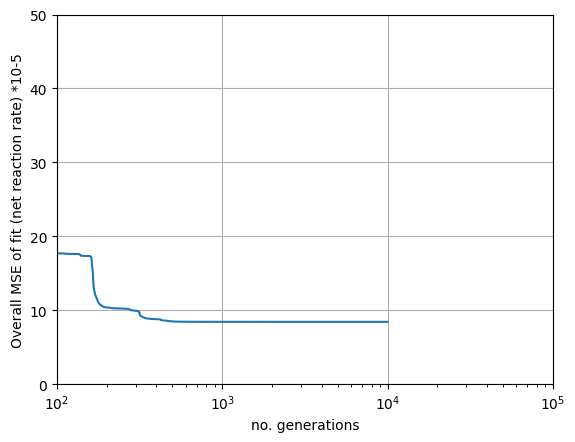

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

0.8012290863568313
8.299902825583885
8.300370190051764
0.6350301059177381
8.108047075405844
8.108937095379401
8.12326982124011
0.7726379316643313
6.761022406444464
6.803068590333823
6.65715746613838
6.7855405076352655
1.3856634646655281
7.373330009208524
7.611776223179285
8.721754675794789e-05
7.405592237860235
2.440851487271699
8.450428428148472
1.1686203395123806
8.16966026012944
8.166790107412732
8.176894698275243
7.180022651169019
0.551895261489971
6.556831192284342
3.2119623666626635
6.177681020215345
8.146751460053347
8.287925684840683
1.5470140474731364
8.549346606204592
-1.30103
0.5723301962480504


In [34]:
res.X

array([ 8.01229086e-01,  8.29990283e+00,  8.30037019e+00,  6.35030106e-01,
        8.10804708e+00,  8.10893710e+00,  8.12326982e+00,  7.72637932e-01,
        6.76102241e+00,  6.80306859e+00,  6.65715747e+00,  6.78554051e+00,
        1.38566346e+00,  7.37333001e+00,  7.61177622e+00,  8.72175468e-05,
        7.40559224e+00,  2.44085149e+00,  8.45042843e+00,  1.16862034e+00,
        8.16966026e+00,  8.16679011e+00,  8.17689470e+00,  7.18002265e+00,
        5.51895261e-01,  6.55683119e+00,  3.21196237e+00,  6.17768102e+00,
        8.14675146e+00,  8.28792568e+00,  1.54701405e+00,  8.54934661e+00,
       -1.30103000e+00,  5.72330196e-01])

In [35]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

array([1. , 8.5, 8.5, 2. , 9. , 9. , 9. , 2. , 8. , 8. , 8. , 8. , 2. ,
       8. , 8. , 8. , 8. , 2. , 8. , 1. , 8. , 8. , 8. , 7. , 1. , 7. ,
       3. , 6. , 8. , 8. , 1. , 8. , 0.1])

In [36]:
for i in range(len (logkr)):
    print (logkr[i])

1.0
8.5
8.5
2.0
9.0
9.0
9.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
1.0
8.0
8.0
8.0
7.0
1.0
7.0
3.0
6.0
8.0
8.0
1.0
8.0
0.10000000000000002


In [37]:
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

1.0: 0.8012290863568313
8.5: 8.299902825583885
8.5: 8.300370190051764
2.0: 0.6350301059177381
9.0: 8.108047075405844
9.0: 8.108937095379401
9.0: 8.12326982124011
2.0: 0.7726379316643313
8.0: 6.761022406444464
8.0: 6.803068590333823
8.0: 6.65715746613838
8.0: 6.7855405076352655
2.0: 1.3856634646655281
8.0: 7.373330009208524
8.0: 7.611776223179285
8.0: 8.721754675794789e-05
8.0: 7.405592237860235
2.0: 2.440851487271699
8.0: 8.450428428148472
1.0: 1.1686203395123806
8.0: 8.16966026012944
8.0: 8.166790107412732
8.0: 8.176894698275243
7.0: 7.180022651169019
1.0: 0.551895261489971
7.0: 6.556831192284342
3.0: 3.2119623666626635
6.0: 6.177681020215345
8.0: 8.146751460053347
8.0: 8.287925684840683
1.0: 1.5470140474731364
8.0: 8.549346606204592
0.10000000000000002: 0.5723301962480504
coeff fit: 0.7435472008398634
r: 0.8622918304378532


In [ ]:
# Use stored solution
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3

import numpy as np
logkr=np.log10(kr)

logkr=np.ndarray.tolist(logkr)

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 =  np.ndarray.tolist(res.X)
krseed10 = 
krseed101 = 

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-2]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([0, 10])
plt.ylim([0, 10])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()